In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
from collections import defaultdict
from Levenshtein import distance

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn import metrics

import scipy.stats as stats
from scipy.stats import wilcoxon
#from scipy.stats import mannwhitneyu
#import collections
#from statistics import mean
#from statistics import median

import copy

In [3]:
log = pd.read_csv("eventsWithPhases.csv")

In [4]:
#create log with Case ID based on currentQuestion + participant

#change data type of currentQuestion from int to str
log = log.astype({'currentQuestion': str})

#combine two columns
log['case_id'] = pd.factorize(log.participant+log.currentQuestion)[0]

In [5]:
# Define conversion function
def convert_ms_to_date(milliseconds):
    date_obj = datetime.fromtimestamp(milliseconds / 1000.0)
    date_string = date_obj.strftime('%Y-%m-%d %H:%M:%S.%f')
    return date_string

# Apply conversion function to 'milliseconds' column
log['fixation_start'] = log['Fixation Start'].apply(convert_ms_to_date)
log['fixation_end'] = log['Fixation End'].apply(convert_ms_to_date)

In [6]:
# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform the 'tabName_element' column
log['activity'] = le.fit_transform(log['tabName_element'])

In [7]:
### log_global_search

In [8]:
#there are 614 cases, although 46 participants * 14 questions = 616 --> 2 cases are missing 
#print(len(log.case_id.unique()))

In [9]:
log

,Number,participant,FixID,Fixation X,Fixation Y,Fixation Start,Fixation End,Fixation Duration,Fixation Dispersion,SacID,...,Type3,Relevant elements labels,Relevant elements count,Relevant elements names,relevant,Phase,case_id,fixation_start,fixation_end,activity
0,0,KP1-no,1101.0,1301.2509,133.2523,5.715801e+06,5.715884e+06,83.4080,0.1208,NaN,...,Exclusiveness,['Send detailed information on final destinati...,2,"['Activity_1fk1rvd', 'Activity_0v934ow']",0,search,0,1970-01-01 02:35:15.800704,1970-01-01 02:35:15.884111,82
1,1,KP1-no,1102.0,577.2880,-37.4236,5.716709e+06,5.716834e+06,124.9670,0.3481,NaN,...,Exclusiveness,['Send detailed information on final destinati...,2,"['Activity_1fk1rvd', 'Activity_0v934ow']",0,search,0,1970-01-01 02:35:16.708983,1970-01-01 02:35:16.833950,82
2,2,KP1-no,1103.0,453.3125,-42.5000,5.716884e+06,5.716951e+06,66.6000,0.2288,NaN,...,Exclusiveness,['Send detailed information on final destinati...,2,"['Activity_1fk1rvd', 'Activity_0v934ow']",0,search,0,1970-01-01 02:35:16.883977,1970-01-01 02:35:16.950577,82
3,3,KP1-no,1104.0,579.9746,-80.0503,5.717900e+06,5.717984e+06,83.3050,1.5229,NaN,...,Exclusiveness,['Send detailed information on final destinati...,2,"['Activity_1fk1rvd', 'Activity_0v934ow']",0,search,0,1970-01-01 02:35:17.900487,1970-01-01 02:35:17.983792,82
4,4,KP1-no,1105.0,647.4488,-46.5585,5.718375e+06,5.718484e+06,108.3100,0.2081,NaN,...,Exclusiveness,['Send detailed information on final destinati...,2,"['Activity_1fk1rvd', 'Activity_0v934ow']",0,search,0,1970-01-01 02:35:18.375424,1970-01-01 02:35:18.483734,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174696,174696,SP11-no,5752.0,789.3538,186.0428,9.295871e+06,9.296079e+06,208.2810,0.2594,NaN,...,Data-based Routing,"['Container [in transition]', 'Collect contain...",3,"['DataObjectReference_09inboe', 'Activity_0qpe...",0,NaN,613,1970-01-01 03:34:55.871112,1970-01-01 03:34:56.079393,650
174697,174697,SP11-no,5753.0,1229.2347,118.4895,9.296179e+06,9.296563e+06,383.2750,0.3156,NaN,...,Data-based Routing,"['Container [in transition]', 'Collect contain...",3,"['DataObjectReference_09inboe', 'Activity_0qpe...",0,NaN,613,1970-01-01 03:34:56.179382,1970-01-01 03:34:56.562657,605
174698,174698,SP11-no,5754.0,1282.5789,124.7105,9.296621e+06,9.296779e+06,158.3300,0.2466,NaN,...,Data-based Routing,"['Container [in transition]', 'Collect contain...",3,"['DataObjectReference_09inboe', 'Activity_0qpe...",0,NaN,613,1970-01-01 03:34:56.620999,1970-01-01 03:34:56.779329,605
174699,174699,SP11-no,5755.0,911.5417,199.0000,9.296846e+06,9.296946e+06,100.0035,0.1728,NaN,...,Data-based Routing,"['Container [in transition]', 'Collect contain...",3,"['DataObjectReference_09inboe', 'Activity_0qpe...",0,NaN,613,1970-01-01 03:34:56.845958,1970-01-01 03:34:56.945961,650


In [10]:
#Select only Control-flow questions
log_select = log[['case_id', 'fixation_start', 'activity', 'Phase', 'Type1', 'Type2', 'Type3', 'Fixation Duration', 'participant']]
log_tasks = log_select.loc[log_select['Type2'] == 'Control-flow']
log_tasks['taskType'] = log_tasks['Type1'] + log_tasks['Type3']



C:\Users\la1949\AppData\Local\Temp\ipykernel_13608\118830956.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_tasks['taskType'] = log_tasks['Type1'] + log_tasks['Type3']


In [11]:
log_tasks = log_tasks.dropna()

In [12]:
log_tasks

,case_id,fixation_start,activity,Phase,Type1,Type2,Type3,Fixation Duration,participant,taskType
0,0,1970-01-01 02:35:15.800704,82,search,Local,Control-flow,Exclusiveness,83.4080,KP1-no,LocalExclusiveness
1,0,1970-01-01 02:35:16.708983,82,search,Local,Control-flow,Exclusiveness,124.9670,KP1-no,LocalExclusiveness
2,0,1970-01-01 02:35:16.883977,82,search,Local,Control-flow,Exclusiveness,66.6000,KP1-no,LocalExclusiveness
3,0,1970-01-01 02:35:17.900487,82,search,Local,Control-flow,Exclusiveness,83.3050,KP1-no,LocalExclusiveness
4,0,1970-01-01 02:35:18.375424,82,search,Local,Control-flow,Exclusiveness,108.3100,KP1-no,LocalExclusiveness
...,...,...,...,...,...,...,...,...,...,...
173388,609,1970-01-01 03:18:25.373217,767,inference,Local,Control-flow,Ordering,624.9325,SP11-no,LocalOrdering
173389,609,1970-01-01 03:18:26.173131,748,inference,Local,Control-flow,Ordering,108.3370,SP11-no,LocalOrdering
173390,609,1970-01-01 03:18:26.289800,753,inference,Local,Control-flow,Ordering,374.9780,SP11-no,LocalOrdering
173391,609,1970-01-01 03:18:26.673098,753,inference,Local,Control-flow,Ordering,83.2995,SP11-no,LocalOrdering


In [13]:
log_global_search = log_tasks.loc[(log_tasks['Type1'] == 'Global') & (log_tasks['Phase'] == 'search')]
log_global_inference = log_tasks.loc[(log_tasks['Type1'] == 'Global') & (log_tasks['Phase'] == 'inference')]
log_local_search = log_tasks.loc[(log_tasks['Type1'] == 'Local') & (log_tasks['Phase'] == 'search')]
log_local_inference = log_tasks.loc[(log_tasks['Type1'] == 'Local') & (log_tasks['Phase'] == 'inference')]


#Create trace logs
logVar_global_search = log_global_search.groupby(['case_id'])['activity'].apply(list).reset_index()
logVar_global_inference = log_global_inference.groupby(['case_id'])['activity'].apply(list).reset_index()
logVar_local_search = log_local_search.groupby(['case_id'])['activity'].apply(list).reset_index()
logVar_local_inference = log_local_inference.groupby(['case_id'])['activity'].apply(list).reset_index()

In [14]:
#log['activity'] = le.fit_transform(log['tabName_element'])
#log_select = log[['case_id', 'fixation_start', 'activity', 'Phase', 'Type1', 'Type2', 'Type3', 'Fixation Duration', 'participant']]
#log_tasks = log_select.loc[log_select['Type2'] == 'Control-flow']
#log_tasks['taskType'] = log_tasks['Type1'] + log_tasks['Type3']

log_global = log_tasks.loc[(log_tasks['Type1'] == 'Global')]
log_local = log_tasks.loc[(log_tasks['Type1'] == 'Local')]


logVar_global = log_global.groupby(['case_id'])['activity'].apply(list).reset_index()
logVar_local = log_local.groupby(['case_id'])['activity'].apply(list).reset_index()

In [15]:
log_global_search_participant = log_global_search.groupby(['case_id'])['participant'].apply(list).reset_index()
log_global_search_participant['participant'] = log_global_search_participant['participant'].apply(lambda x: set(x))
log_global_search_participant['participant'] = log_global_search_participant['participant'].apply(lambda x: ''.join(x))
logVar_global_search = pd.merge(logVar_global_search, log_global_search_participant, on='case_id')


log_global_inference_participant = log_global_inference.groupby(['case_id'])['participant'].apply(list).reset_index()
log_global_inference_participant['participant'] = log_global_inference_participant['participant'].apply(lambda x: set(x))
log_global_inference_participant['participant'] = log_global_inference_participant['participant'].apply(lambda x: ''.join(x))
logVar_global_inference = pd.merge(logVar_global_inference, log_global_inference_participant, on='case_id')

log_local_search_participant = log_local_search.groupby(['case_id'])['participant'].apply(list).reset_index()
log_local_search_participant['participant'] = log_local_search_participant['participant'].apply(lambda x: set(x))
log_local_search_participant['participant'] = log_local_search_participant['participant'].apply(lambda x: ''.join(x))
logVar_local_search = pd.merge(logVar_local_search, log_local_search_participant, on='case_id')

log_local_inference_participant = log_local_inference.groupby(['case_id'])['participant'].apply(list).reset_index()
log_local_inference_participant['participant'] = log_local_inference_participant['participant'].apply(lambda x: set(x))
log_local_inference_participant['participant'] = log_local_inference_participant['participant'].apply(lambda x: ''.join(x))
logVar_local_inference = pd.merge(logVar_local_inference, log_local_inference_participant, on='case_id')


In [16]:
log_global_participant = log_global.groupby(['case_id'])['participant'].apply(list).reset_index()
log_global_participant['participant'] = log_global_participant['participant'].apply(lambda x: set(x))
log_global_participant['participant'] = log_global_participant['participant'].apply(lambda x: ''.join(x))
logVar_global = pd.merge(logVar_global, log_global_participant, on='case_id')

log_local_participant = log_local.groupby(['case_id'])['participant'].apply(list).reset_index()
log_local_participant['participant'] = log_local_participant['participant'].apply(lambda x: set(x))
log_local_participant['participant'] = log_local_participant['participant'].apply(lambda x: ''.join(x))
logVar_local = pd.merge(logVar_local, log_local_participant, on='case_id')

In [17]:
log_tasks.Phase.unique()

array(['search', 'inference'], dtype=object)

In [18]:
logVar_global['cpoint'] = logVar_global_search['activity'].apply(lambda x: len(x))

In [19]:
logVar_global['length'] = logVar_global['activity'].apply(lambda x: len(x))

In [20]:
logVar_global

,case_id,activity,participant,cpoint,length
0,5,"[90, 82, 183, 82, 82, 82, 82, 82, 183, 77, 75,...",KP1-no,186,335
1,9,"[82, 82, 82, 110, 82, 179, 82, 82, 82, 82, 82,...",KP1-no,43,55
2,18,"[89, 50, 56, 181, 181, 181, 181, 181, 181, 181...",KP10-no,372,627
3,19,"[93, 50, 183, 59, 183, 183, 183, 183, 183, 183...",KP10-no,66,318
4,23,"[88, 110, 179, 179, 179, 179, 179, 179, 112, 7...",KP10-no,185,512
...,...,...,...,...,...
151,592,"[82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 8...",SP9-no,99,321
152,597,"[179, 82, 179, 82, 82, 82, 82, 82, 82, 82, 82,...",SP9-no,287,387
153,598,"[82, 82, 82, 82, 82, 82, 82, 50, 50, 3, 27, 32...",SP9-no,276,1152
154,605,"[50, 181, 181, 181, 82, 181, 56, 181, 113, 181...",SP11-no,308,445


In [21]:
logVar_local

,case_id,activity,participant
0,0,"[82, 82, 82, 82, 82, 177, 82, 82, 82, 82, 82, ...",KP1-no
1,6,"[82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 8...",KP1-no
2,14,"[52, 104, 177, 82, 82, 177, 104, 104, 104, 106...",KP10-no
3,20,"[83, 50, 103, 175, 175, 175, 175, 175, 51, 175...",KP10-no
4,21,"[53, 53, 178, 108, 82, 178, 82, 178, 178, 53, ...",KP10-no
...,...,...,...
162,595,"[148, 178, 178, 82, 82, 82, 82, 82, 82, 82, 82...",SP9-no
163,596,"[100, 195, 82, 82, 82, 82, 82, 195, 195, 82, 8...",SP9-no
164,607,"[82, 82, 82, 102, 175, 175, 175, 175, 175, 175...",SP11-no
165,608,"[86, 86, 82, 108, 109, 86, 178, 86, 178, 108, ...",SP11-no


In [22]:
logVar_local['cpoint'] = logVar_local_search['activity'].apply(lambda x: len(x))

In [23]:
logVar_local['length'] = logVar_local['activity'].apply(lambda x: len(x))

In [24]:
logVar_local

,case_id,activity,participant,cpoint,length
0,0,"[82, 82, 82, 82, 82, 177, 82, 82, 82, 82, 82, ...",KP1-no,101,287
1,6,"[82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 8...",KP1-no,153,173
2,14,"[52, 104, 177, 82, 82, 177, 104, 104, 104, 106...",KP10-no,79,156
3,20,"[83, 50, 103, 175, 175, 175, 175, 175, 51, 175...",KP10-no,55,114
4,21,"[53, 53, 178, 108, 82, 178, 82, 178, 178, 53, ...",KP10-no,102,184
...,...,...,...,...,...
162,595,"[148, 178, 178, 82, 82, 82, 82, 82, 82, 82, 82...",SP9-no,111,148
163,596,"[100, 195, 82, 82, 82, 82, 82, 195, 195, 82, 8...",SP9-no,258,449
164,607,"[82, 82, 82, 102, 175, 175, 175, 175, 175, 175...",SP11-no,92,173
165,608,"[86, 86, 82, 108, 109, 86, 178, 86, 178, 108, ...",SP11-no,108,198


In [25]:
print(logVar_local['length'].min(), logVar_local['length'].max(), logVar_local['length'].mean())

56 798 182.88622754491018


In [26]:
print(logVar_global['length'].min(), logVar_global['length'].max(), logVar_global['length'].mean())

55 1152 407.72435897435895


# Concept Drift

### Distance Measures

In [27]:
# Feature Generation / Encoding Functions , input: sorted window, pandasSeries, group output: time series
from nltk import ngrams
from Levenshtein import distance
import textdistance 
from scipy.stats import wasserstein_distance

In [28]:
# Distance Measures

def levenshtein_distance(v1, v2): 
    v1 = list(v1)
    v2 = list(v2)
    return textdistance.levenshtein.distance(v1, v2)


# 1-gram Jaccard distance

def jacc(v1, v2): 
    v1 = list(v1)
    v2 = list(v2)
    return textdistance.jaccard.distance(v1, v2)

def jacc_bigram(v1, v2): 
    v1 = list(ngrams(v1,2))
    v2 = list(ngrams(v2,2))
    return textdistance.jaccard.distance(v1, v2)

def jacc_trigram(v1, v2): 
    v1 = list(ngrams(v1,3))
    v2 = list(ngrams(v2,3))
    return textdistance.jaccard.distance(v1, v2)

In [29]:
#Create 1-gram vector for Cosine and Euclidean distance

def createVector(charList):
    arrayList = np.array(charList)
    unique, counts = np.unique(arrayList, return_counts=True)
    
    #calculate relative frequency
    relFrequList = np.array((unique, counts)).T
    uniqueList = list(unique)
    return relFrequList[relFrequList[:, 0].argsort()]


        
#test
x_test = pd.Series(logVar_global['activity'][0])
t1 = x_test[0:10]
t2 = x_test[10:20]

vec1 = createVector(t1)
vec2 = createVector(t2)

print('v1:',vec1, 'v2:',vec2)

v1: [[ 77   1]
 [ 82   6]
 [ 90   1]
 [183   2]] v2: [[ 75   1]
 [672   1]
 [673   2]
 [677   1]
 [722   1]
 [729   2]
 [748   1]
 [796   1]]


In [30]:
def alignArrays(array1, array2):
    
    commonSet = set(array1[:,0]).union(array2[:,0])
    
    val1 = array1[:,0] # NEW
    val2 = array2[:,0] # NEW
    
    for i in commonSet:
        if i not in val1:
            array1 = np.append(array1, np.array([[i, '0']]), axis=0)

    for i in commonSet:
        if i not in val2:
            array2 = np.append(array2, np.array([[i, '0']]), axis=0)
            
    return array1[array1[:, 0].argsort()], array2[array2[:, 0].argsort()]

#test
x_test = pd.Series(logVar_global['activity'][0])
t1 = x_test[0:10]
t2 = x_test[10:20]

vec1 = createVector(t1)
vec2 = createVector(t2)


alignArrays(vec1,vec2)

(array([['183', '2'],
        ['672', '0'],
        ['673', '0'],
        ['677', '0'],
        ['722', '0'],
        ['729', '0'],
        ['748', '0'],
        ['75', '0'],
        ['77', '1'],
        ['796', '0'],
        ['82', '6'],
        ['90', '1']], dtype='<U21'),
 array([['183', '0'],
        ['672', '1'],
        ['673', '2'],
        ['677', '1'],
        ['722', '1'],
        ['729', '2'],
        ['748', '1'],
        ['75', '1'],
        ['77', '0'],
        ['796', '1'],
        ['82', '0'],
        ['90', '0']], dtype='<U21'))

In [31]:
#Cosine distance based on 1-gram
from scipy.spatial import distance

def cosineSim1(v1,v2):

    l1 = list(v1.astype(str))
    l2 = list(v2.astype(str))
    
    vec1 = createVector(l1)
    vec2 = createVector(l2)
    
    align1, align2 = alignArrays(vec1, vec2)
    
    a = align1[:,1].astype(int)
    b = align2[:,1].astype(int)
    
    return distance.cosine(a, b)

#test
x_test = pd.Series(logVar_global['activity'][0])
t1 = x_test[0:20]
t2 = x_test[20:40]

cosineSim1(t1,t2)

0.826578006095176

In [32]:
#Create 2-gram

def df_list(list_of_char):
    extList = list_of_char.copy()
    extList.insert(0, '*') 
    extList.append('$')
    list_new = []
    for i in range(len(extList)):
        new = ''.join(extList[i:i+2])
        list_new.append(new)
    del list_new[-1]
    return list_new

In [33]:
#Cosine distance based on 2-gram

def cosineSim2(v1,v2):

    l1 = df_list(list(v1.astype(str)))
    l2 = df_list(list(v2.astype(str)))
    
    vec1 = createVector(l1)
    vec2 = createVector(l2)
    
    align1, align2 = alignArrays(vec1, vec2)
    
    a = align1[:,1].astype(int)
    b = align2[:,1].astype(int)
    
    return distance.cosine(a, b)

#test
x_test = pd.Series(logVar_global['activity'][0])
t1 = x_test[0:20]
t2 = x_test[20:40]

cosineSim2(t1,t2)

0.9807371467867645

In [34]:
#Euclidean distance based on 1-gram

def eucliDist1(v1,v2):

    l1 = list(v1.astype(str))
    l2 = list(v2.astype(str))
    
    vec1 = createVector(l1)
    vec2 = createVector(l2)
    
    align1, align2 = alignArrays(vec1, vec2)
    
    a = align1[:,1].astype(int)
    b = align2[:,1].astype(int)
    
    return np.linalg.norm(a-b)

In [35]:
#Euclidean distance based on 2-gram

def eucliDist2(v1,v2):

    l1 = df_list(list(v1.astype(str)))
    l2 = df_list(list(v2.astype(str)))
    
    vec1 = createVector(l1)
    vec2 = createVector(l2)
    
    align1, align2 = alignArrays(vec1, vec2)
    
    a = align1[:,1].astype(int)
    b = align2[:,1].astype(int)
    
    return np.linalg.norm(a-b)

### Generate Time Series

In [36]:
def generate_timeS(pd_ser, distance_function, window_size):
    
    w_1 = {}
    w_2 = {}
    for i in range(len(pd_ser) - 2*window_size+1):
        w_1[i+window_size] = pd_ser[i:i+window_size]
        w_2[i+window_size] = pd_ser[i+window_size:i+2*window_size]
    
    distances = []
    index = []
    
    for j in range(len(pd_ser)):
        if j in w_1:
            distance = distance_function(w_1[j], w_2[j])
        else:
            distance = np.nan    
        distances.append(distance)
        index.append(j) #erstes Element aus zweiter Stichprobe als Change Point festgelegt   
    
    return pd.Series(distances, index=index)

#test
#test = pd.Series([0,1,2,3,4,5,3])
#generate_timeS(test, levenshtein_distance,3)

In [37]:
logVar_global

,case_id,activity,participant,cpoint,length
0,5,"[90, 82, 183, 82, 82, 82, 82, 82, 183, 77, 75,...",KP1-no,186,335
1,9,"[82, 82, 82, 110, 82, 179, 82, 82, 82, 82, 82,...",KP1-no,43,55
2,18,"[89, 50, 56, 181, 181, 181, 181, 181, 181, 181...",KP10-no,372,627
3,19,"[93, 50, 183, 59, 183, 183, 183, 183, 183, 183...",KP10-no,66,318
4,23,"[88, 110, 179, 179, 179, 179, 179, 179, 112, 7...",KP10-no,185,512
...,...,...,...,...,...
151,592,"[82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 8...",SP9-no,99,321
152,597,"[179, 82, 179, 82, 82, 82, 82, 82, 82, 82, 82,...",SP9-no,287,387
153,598,"[82, 82, 82, 82, 82, 82, 82, 50, 50, 3, 27, 32...",SP9-no,276,1152
154,605,"[50, 181, 181, 181, 82, 181, 56, 181, 113, 181...",SP11-no,308,445


### Concept Drift Detection Algorithm

In [38]:
import ruptures as rpt
#from hotelling.stats import hotelling_t2
#from scipy.stats import chi2

# splits time series at a change point and finds new change points in the smaller segments etc.
def bin_seg(ts, model="rank", min_size=2, jump=5): # model = "l2", "l1", "rbf", "linear", "normal", "ar"
    n = ts.shape[0]
    dim = ts.shape[1]
    sigma = np.std(ts)
    if ts.shape[0] < ts.shape[1]:
        print('Caution, time series might not be in the right format.')
    algo = rpt.Binseg(model=model, min_size=min_size, jump=jump).fit(ts)
    result = algo.predict(n_bkps=1)
    #result = algo.predict(pen=np.log(n) * dim) # n_bkps=1 if number of cp is known, otherwise
    # Penalty: 'pen=np.log(n) * dim * sigma**2' or Residual 'epsilon=3 * n * sigma**2'
    return result


#test
x_win = pd.Series(logVar_global["activity"][0])
x_win_matrix = x_win.to_numpy().reshape(-1, 1)
detected_cp = bin_seg(x_win_matrix)
detected_cp = detected_cp[:-1]
detected_cp

[180]

### Performance Evaluation

In [39]:
def absolute_error(actual_cps, detected_cps):
    return abs(detected_cps - actual_cps)

In [40]:
def normalized_absolute_error(actual_cps, detected_cps, time_series):
    return abs(detected_cps - actual_cps) / len(time_series)

In [41]:
def signed_difference(actual_cps, detected_cps):
    return detected_cps - actual_cps

In [42]:
def normalized_signed_difference(actual_cps, detected_cps, time_series):
    return (detected_cps - actual_cps) / len(time_series)

In [56]:
#Datframe to collect results
d= {'measure':[],'window':[],'mae':[], 'mae_std':[], 'nmae':[], 'nmae_std':[],'msd':[], 'msd_std':[], 'nmsd':[], 'nmsd_std':[]}
df_results = pd.DataFrame(data=d)
df_results

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std


In [ ]:
#df_results.to_csv('df_results.txt', index=False)  

In [54]:
import statistics

def evalFunction(inputLog,distanceFunctionList,window_size,results):
    for i in distanceFunctionList:
        errorList = []
        errorList_norm = []
        errorList_sign = []
        errorList_sign_norm = []
        for index, row in inputLog.iterrows(): #iterate over rows in df
            
            #generate timer series
            x_ser = pd.Series(row['activity'])
            time_ser = generate_timeS(x_ser,i,window_size)
            
            #apply cp detection algorithm
            time_ser_matrix = time_ser.to_numpy().reshape(-1, 1)
            detected_cp = bin_seg(time_ser_matrix)
            
            #evaluate detected cp
            act_cp = row['cpoint']
            
            #absolute error
            error = absolute_error(int(act_cp),detected_cp[0])
            errorList.append(error)
            
            #normalized error
            error_norm = normalized_absolute_error(int(act_cp),detected_cp[0],x_ser)
            errorList_norm.append(error_norm)
            
            #signed error
            error_sign = signed_difference(int(act_cp),detected_cp[0])
            errorList_sign.append(error_sign)
            
            #signed error
            error_sign_norm = normalized_signed_difference(int(act_cp),detected_cp[0],x_ser)
            errorList_sign_norm.append(error_sign_norm)
            
            
            

        #Save results
        a = statistics.mean(errorList)
        b = statistics.stdev(errorList)
        c = statistics.mean(errorList_norm)
        d = statistics.stdev(errorList_norm)
        e = statistics.mean(errorList_sign)
        f = statistics.stdev(errorList_sign)
        g = statistics.mean(errorList_sign_norm)
        h = statistics.stdev(errorList_sign_norm)
    
        resultList = [str(i),str(window_size), str(round(a, 3)), '(' + str(round(b, 3)) +')',str(round(c, 3)),'(' + str(round(d, 3)) +')',str(round(e, 3)),'(' + str(round(f, 3)) +')',str(round(g, 3)),'(' + str(round(h, 3)) +')']
        results.loc[len(df_results)] = resultList
        
        print(str(i), ' mae:', a, 'std:', b)
        print(str(i), ' norm_mae:', c, 'std:', d)
        print(str(i), ' msd:', e, 'std:', f)
        print(str(i), ' norm_msd:', g, 'std:', h)
        print('------------------')
        
    return results

In [58]:
distanceList= [levenshtein_distance,cosineSim1,cosineSim2,eucliDist1,eucliDist2,jacc,jacc_bigram,jacc_trigram]

In [59]:
#global
evalFunction(logVar_global,distanceList,20,df_results)

<function levenshtein_distance at 0x0000022A944FFA60>  mae: 125.77564102564102 std: 89.6539996925779
<function levenshtein_distance at 0x0000022A944FFA60>  norm_mae: 0.34386035090115413 std: 0.20350611809398134
<function levenshtein_distance at 0x0000022A944FFA60>  msd: -76.60897435897436 std: 134.36001583218552
<function levenshtein_distance at 0x0000022A944FFA60>  norm_msd: -0.2559901722637252 std: 0.30734959023211
------------------
<function cosineSim1 at 0x0000022A944FFE50>  mae: 124.01923076923077 std: 100.31656159885749
<function cosineSim1 at 0x0000022A944FFE50>  norm_mae: 0.340204761050089 std: 0.22266402210748362
<function cosineSim1 at 0x0000022A944FFE50>  msd: -62.18589743589744 std: 147.14407267170233
<function cosineSim1 at 0x0000022A944FFE50>  norm_msd: -0.2337505077111248 std: 0.3332768214918418
------------------
<function cosineSim2 at 0x0000022A944FF310>  mae: 117.9423076923077 std: 87.9929792202739
<function cosineSim2 at 0x0000022A944FF310>  norm_mae: 0.32861059511

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std
0,<function levenshtein_distance at 0x0000022A94...,20,125.776,(89.654),0.344,(0.204),-76.609,(134.36),-0.256,(0.307)
1,<function cosineSim1 at 0x0000022A944FFE50>,20,124.019,(100.317),0.34,(0.223),-62.186,(147.144),-0.234,(0.333)
2,<function cosineSim2 at 0x0000022A944FF310>,20,117.942,(87.993),0.329,(0.206),-86.288,(119.37),-0.276,(0.273)
3,<function eucliDist1 at 0x0000022A944FDB80>,20,134.667,(111.219),0.357,(0.219),-68.756,(160.822),-0.242,(0.342)
4,<function eucliDist2 at 0x0000022A9157BDC0>,20,134.442,(123.744),0.341,(0.213),-52.699,(175.239),-0.208,(0.344)
5,<function jacc at 0x0000022A981FB8B0>,20,120.846,(97.59),0.335,(0.222),-69.526,(139.129),-0.248,(0.317)
6,<function jacc_bigram at 0x0000022A981FB940>,20,114.25,(84.726),0.322,(0.208),-86.994,(112.69),-0.28,(0.262)
7,<function jacc_trigram at 0x0000022A981FBA60>,20,124.019,(78.608),0.347,(0.2),-112.571,(94.368),-0.332,(0.225)


In [60]:
#global
evalFunction(logVar_global,distanceList,40,df_results)

<function levenshtein_distance at 0x0000022A944FFA60>  mae: 118.8076923076923 std: 95.17088978793512
<function levenshtein_distance at 0x0000022A944FFA60>  norm_mae: 0.31156085136690426 std: 0.18827001648148026
<function levenshtein_distance at 0x0000022A944FFA60>  msd: -79.52564102564102 std: 129.99500976615434
<function levenshtein_distance at 0x0000022A944FFA60>  norm_msd: -0.2559280343020049 std: 0.25926875703463614
------------------
<function cosineSim1 at 0x0000022A944FFE50>  mae: 106.48717948717949 std: 87.56707933328097
<function cosineSim1 at 0x0000022A944FFE50>  norm_mae: 0.2917141908165507 std: 0.1973359060859308
<function cosineSim1 at 0x0000022A944FFE50>  msd: -92.6025641025641 std: 102.22578927737834
<function cosineSim1 at 0x0000022A944FFE50>  norm_msd: -0.2727384062000669 std: 0.22298316868769275
------------------
<function cosineSim2 at 0x0000022A944FF310>  mae: 112.99358974358974 std: 95.08200174279936
<function cosineSim2 at 0x0000022A944FF310>  norm_mae: 0.3017802

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std
0,<function levenshtein_distance at 0x0000022A94...,20,125.776,(89.654),0.344,(0.204),-76.609,(134.36),-0.256,(0.307)
1,<function cosineSim1 at 0x0000022A944FFE50>,20,124.019,(100.317),0.34,(0.223),-62.186,(147.144),-0.234,(0.333)
2,<function cosineSim2 at 0x0000022A944FF310>,20,117.942,(87.993),0.329,(0.206),-86.288,(119.37),-0.276,(0.273)
3,<function eucliDist1 at 0x0000022A944FDB80>,20,134.667,(111.219),0.357,(0.219),-68.756,(160.822),-0.242,(0.342)
4,<function eucliDist2 at 0x0000022A9157BDC0>,20,134.442,(123.744),0.341,(0.213),-52.699,(175.239),-0.208,(0.344)
5,<function jacc at 0x0000022A981FB8B0>,20,120.846,(97.59),0.335,(0.222),-69.526,(139.129),-0.248,(0.317)
6,<function jacc_bigram at 0x0000022A981FB940>,20,114.25,(84.726),0.322,(0.208),-86.994,(112.69),-0.28,(0.262)
7,<function jacc_trigram at 0x0000022A981FBA60>,20,124.019,(78.608),0.347,(0.2),-112.571,(94.368),-0.332,(0.225)
8,<function levenshtein_distance at 0x0000022A94...,40,118.808,(95.171),0.312,(0.188),-79.526,(129.995),-0.256,(0.259)
9,<function cosineSim1 at 0x0000022A944FFE50>,40,106.487,(87.567),0.292,(0.197),-92.603,(102.226),-0.273,(0.223)


In [61]:
#global
evalFunction(logVar_global,distanceList,60,df_results)

<function levenshtein_distance at 0x0000022A944FFA60>  mae: 99.83333333333333 std: 84.95082701629624
<function levenshtein_distance at 0x0000022A944FFA60>  norm_mae: 0.25856046883574524 std: 0.17306894814103502
<function levenshtein_distance at 0x0000022A944FFA60>  msd: -85.8076923076923 std: 99.18253718463818
<function levenshtein_distance at 0x0000022A944FFA60>  norm_msd: -0.23642895171470757 std: 0.20243123327816556
------------------
<function cosineSim1 at 0x0000022A944FFE50>  mae: 93.0576923076923 std: 84.50235655310031
<function cosineSim1 at 0x0000022A944FFE50>  norm_mae: 0.2478793536201706 std: 0.17931024133036155
<function cosineSim1 at 0x0000022A944FFE50>  msd: -79.17307692307692 std: 97.71097362755965
<function cosineSim1 at 0x0000022A944FFE50>  norm_msd: -0.2262687435354738 std: 0.20607013268314453
------------------
<function cosineSim2 at 0x0000022A944FF310>  mae: 92.76923076923077 std: 79.62240292245896
<function cosineSim2 at 0x0000022A944FF310>  norm_mae: 0.2479284698

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std
0,<function levenshtein_distance at 0x0000022A94...,20,125.776,(89.654),0.344,(0.204),-76.609,(134.36),-0.256,(0.307)
1,<function cosineSim1 at 0x0000022A944FFE50>,20,124.019,(100.317),0.34,(0.223),-62.186,(147.144),-0.234,(0.333)
2,<function cosineSim2 at 0x0000022A944FF310>,20,117.942,(87.993),0.329,(0.206),-86.288,(119.37),-0.276,(0.273)
3,<function eucliDist1 at 0x0000022A944FDB80>,20,134.667,(111.219),0.357,(0.219),-68.756,(160.822),-0.242,(0.342)
4,<function eucliDist2 at 0x0000022A9157BDC0>,20,134.442,(123.744),0.341,(0.213),-52.699,(175.239),-0.208,(0.344)
5,<function jacc at 0x0000022A981FB8B0>,20,120.846,(97.59),0.335,(0.222),-69.526,(139.129),-0.248,(0.317)
6,<function jacc_bigram at 0x0000022A981FB940>,20,114.25,(84.726),0.322,(0.208),-86.994,(112.69),-0.28,(0.262)
7,<function jacc_trigram at 0x0000022A981FBA60>,20,124.019,(78.608),0.347,(0.2),-112.571,(94.368),-0.332,(0.225)
8,<function levenshtein_distance at 0x0000022A94...,40,118.808,(95.171),0.312,(0.188),-79.526,(129.995),-0.256,(0.259)
9,<function cosineSim1 at 0x0000022A944FFE50>,40,106.487,(87.567),0.292,(0.197),-92.603,(102.226),-0.273,(0.223)


In [62]:
#global
evalFunction(logVar_global,distanceList,80,df_results)

<function levenshtein_distance at 0x0000022A944FFA60>  mae: 85.1923076923077 std: 80.17433547887322
<function levenshtein_distance at 0x0000022A944FFA60>  norm_mae: 0.21472458893210883 std: 0.15667465246892606
<function levenshtein_distance at 0x0000022A944FFA60>  msd: -65.1025641025641 std: 97.29742757513068
<function levenshtein_distance at 0x0000022A944FFA60>  norm_msd: -0.1774402004872716 std: 0.19814869197054216
------------------
<function cosineSim1 at 0x0000022A944FFE50>  mae: 80.80128205128206 std: 74.3079399110863
<function cosineSim1 at 0x0000022A944FFE50>  norm_mae: 0.2080781612397443 std: 0.15496426380159664
<function cosineSim1 at 0x0000022A944FFE50>  msd: -70.19871794871794 std: 84.45700718627123
<function cosineSim1 at 0x0000022A944FFE50>  norm_msd: -0.18228797264276148 std: 0.1847876934023238
------------------
<function cosineSim2 at 0x0000022A944FF310>  mae: 80.69871794871794 std: 74.00840578865348
<function cosineSim2 at 0x0000022A944FF310>  norm_mae: 0.208315471122

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std
0,<function levenshtein_distance at 0x0000022A94...,20,125.776,(89.654),0.344,(0.204),-76.609,(134.36),-0.256,(0.307)
1,<function cosineSim1 at 0x0000022A944FFE50>,20,124.019,(100.317),0.34,(0.223),-62.186,(147.144),-0.234,(0.333)
2,<function cosineSim2 at 0x0000022A944FF310>,20,117.942,(87.993),0.329,(0.206),-86.288,(119.37),-0.276,(0.273)
3,<function eucliDist1 at 0x0000022A944FDB80>,20,134.667,(111.219),0.357,(0.219),-68.756,(160.822),-0.242,(0.342)
4,<function eucliDist2 at 0x0000022A9157BDC0>,20,134.442,(123.744),0.341,(0.213),-52.699,(175.239),-0.208,(0.344)
5,<function jacc at 0x0000022A981FB8B0>,20,120.846,(97.59),0.335,(0.222),-69.526,(139.129),-0.248,(0.317)
6,<function jacc_bigram at 0x0000022A981FB940>,20,114.25,(84.726),0.322,(0.208),-86.994,(112.69),-0.28,(0.262)
7,<function jacc_trigram at 0x0000022A981FBA60>,20,124.019,(78.608),0.347,(0.2),-112.571,(94.368),-0.332,(0.225)
8,<function levenshtein_distance at 0x0000022A94...,40,118.808,(95.171),0.312,(0.188),-79.526,(129.995),-0.256,(0.259)
9,<function cosineSim1 at 0x0000022A944FFE50>,40,106.487,(87.567),0.292,(0.197),-92.603,(102.226),-0.273,(0.223)


In [63]:
#global
evalFunction(logVar_global,distanceList,100,df_results)

<function levenshtein_distance at 0x0000022A944FFA60>  mae: 70.08333333333333 std: 68.70121925323976
<function levenshtein_distance at 0x0000022A944FFA60>  norm_mae: 0.17836828841759544 std: 0.14037929714517047
<function levenshtein_distance at 0x0000022A944FFA60>  msd: -51.92948717948718 std: 83.36156089333997
<function levenshtein_distance at 0x0000022A944FFA60>  norm_msd: -0.131103547760186 std: 0.18554735668016145
------------------
<function cosineSim1 at 0x0000022A944FFE50>  mae: 70.17307692307692 std: 67.9290107117564
<function cosineSim1 at 0x0000022A944FFE50>  norm_mae: 0.1791984444601799 std: 0.14010625763746573
<function cosineSim1 at 0x0000022A944FFE50>  msd: -53.98076923076923 std: 81.47182146182625
<function cosineSim1 at 0x0000022A944FFE50>  norm_msd: -0.13371638290220483 std: 0.18426501105289478
------------------
<function cosineSim2 at 0x0000022A944FF310>  mae: 73.56410256410257 std: 70.8406826333824
<function cosineSim2 at 0x0000022A944FF310>  norm_mae: 0.18223140455

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std
0,<function levenshtein_distance at 0x0000022A94...,20,125.776,(89.654),0.344,(0.204),-76.609,(134.36),-0.256,(0.307)
1,<function cosineSim1 at 0x0000022A944FFE50>,20,124.019,(100.317),0.34,(0.223),-62.186,(147.144),-0.234,(0.333)
2,<function cosineSim2 at 0x0000022A944FF310>,20,117.942,(87.993),0.329,(0.206),-86.288,(119.37),-0.276,(0.273)
3,<function eucliDist1 at 0x0000022A944FDB80>,20,134.667,(111.219),0.357,(0.219),-68.756,(160.822),-0.242,(0.342)
4,<function eucliDist2 at 0x0000022A9157BDC0>,20,134.442,(123.744),0.341,(0.213),-52.699,(175.239),-0.208,(0.344)
5,<function jacc at 0x0000022A981FB8B0>,20,120.846,(97.59),0.335,(0.222),-69.526,(139.129),-0.248,(0.317)
6,<function jacc_bigram at 0x0000022A981FB940>,20,114.25,(84.726),0.322,(0.208),-86.994,(112.69),-0.28,(0.262)
7,<function jacc_trigram at 0x0000022A981FBA60>,20,124.019,(78.608),0.347,(0.2),-112.571,(94.368),-0.332,(0.225)
8,<function levenshtein_distance at 0x0000022A94...,40,118.808,(95.171),0.312,(0.188),-79.526,(129.995),-0.256,(0.259)
9,<function cosineSim1 at 0x0000022A944FFE50>,40,106.487,(87.567),0.292,(0.197),-92.603,(102.226),-0.273,(0.223)


In [64]:
df_results.to_csv('df_results_global.txt', index=False) 

In [65]:
#local
evalFunction(logVar_local,distanceList,20,df_results)

<function levenshtein_distance at 0x0000022A944FFA60>  mae: 71.1497005988024 std: 72.52316860734629
<function levenshtein_distance at 0x0000022A944FFA60>  norm_mae: 0.3879512450575426 std: 0.201357011086719
<function levenshtein_distance at 0x0000022A944FFA60>  msd: -64.59880239520957 std: 78.44897504304369
<function levenshtein_distance at 0x0000022A944FFA60>  norm_msd: -0.36965421657093994 std: 0.2334311038003631
------------------
<function cosineSim1 at 0x0000022A944FFE50>  mae: 66.94011976047904 std: 63.859663589158615
<function cosineSim1 at 0x0000022A944FFE50>  norm_mae: 0.37507789267589453 std: 0.20701551156545575
<function cosineSim1 at 0x0000022A944FFE50>  msd: -61.75449101796407 std: 68.9161763466269
<function cosineSim1 at 0x0000022A944FFE50>  norm_msd: -0.36056242425380564 std: 0.23151222884981668
------------------
<function cosineSim2 at 0x0000022A944FF310>  mae: 72.23952095808383 std: 72.64903332558961
<function cosineSim2 at 0x0000022A944FF310>  norm_mae: 0.39369585877

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std
0,<function levenshtein_distance at 0x0000022A94...,20,125.776,(89.654),0.344,(0.204),-76.609,(134.36),-0.256,(0.307)
1,<function cosineSim1 at 0x0000022A944FFE50>,20,124.019,(100.317),0.34,(0.223),-62.186,(147.144),-0.234,(0.333)
2,<function cosineSim2 at 0x0000022A944FF310>,20,117.942,(87.993),0.329,(0.206),-86.288,(119.37),-0.276,(0.273)
3,<function eucliDist1 at 0x0000022A944FDB80>,20,134.667,(111.219),0.357,(0.219),-68.756,(160.822),-0.242,(0.342)
4,<function eucliDist2 at 0x0000022A9157BDC0>,20,134.442,(123.744),0.341,(0.213),-52.699,(175.239),-0.208,(0.344)
5,<function jacc at 0x0000022A981FB8B0>,20,120.846,(97.59),0.335,(0.222),-69.526,(139.129),-0.248,(0.317)
6,<function jacc_bigram at 0x0000022A981FB940>,20,114.25,(84.726),0.322,(0.208),-86.994,(112.69),-0.28,(0.262)
7,<function jacc_trigram at 0x0000022A981FBA60>,20,124.019,(78.608),0.347,(0.2),-112.571,(94.368),-0.332,(0.225)
8,<function levenshtein_distance at 0x0000022A94...,40,118.808,(95.171),0.312,(0.188),-79.526,(129.995),-0.256,(0.259)
9,<function cosineSim1 at 0x0000022A944FFE50>,40,106.487,(87.567),0.292,(0.197),-92.603,(102.226),-0.273,(0.223)


In [66]:
evalFunction(logVar_local,distanceList,30,df_results)

<function levenshtein_distance at 0x0000022A944FFA60>  mae: 63.80239520958084 std: 70.18505998309627
<function levenshtein_distance at 0x0000022A944FFA60>  norm_mae: 0.3363589261869901 std: 0.19166982539956431
<function levenshtein_distance at 0x0000022A944FFA60>  msd: -60.01796407185629 std: 73.4666937940918
<function levenshtein_distance at 0x0000022A944FFA60>  norm_msd: -0.32580918529717645 std: 0.20920111498874305
------------------
<function cosineSim1 at 0x0000022A944FFE50>  mae: 64.8443113772455 std: 72.20669595221896
<function cosineSim1 at 0x0000022A944FFE50>  norm_mae: 0.33702532726603346 std: 0.1921634740182083
<function cosineSim1 at 0x0000022A944FFE50>  msd: -61.93413173652694 std: 74.73270745093072
<function cosineSim1 at 0x0000022A944FFE50>  norm_msd: -0.3286146497888846 std: 0.2062983512096945
------------------
<function cosineSim2 at 0x0000022A944FF310>  mae: 64.72455089820359 std: 71.66956174255137
<function cosineSim2 at 0x0000022A944FF310>  norm_mae: 0.337275829226

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std
0,<function levenshtein_distance at 0x0000022A94...,20,125.776,(89.654),0.344,(0.204),-76.609,(134.36),-0.256,(0.307)
1,<function cosineSim1 at 0x0000022A944FFE50>,20,124.019,(100.317),0.34,(0.223),-62.186,(147.144),-0.234,(0.333)
2,<function cosineSim2 at 0x0000022A944FF310>,20,117.942,(87.993),0.329,(0.206),-86.288,(119.37),-0.276,(0.273)
3,<function eucliDist1 at 0x0000022A944FDB80>,20,134.667,(111.219),0.357,(0.219),-68.756,(160.822),-0.242,(0.342)
4,<function eucliDist2 at 0x0000022A9157BDC0>,20,134.442,(123.744),0.341,(0.213),-52.699,(175.239),-0.208,(0.344)
5,<function jacc at 0x0000022A981FB8B0>,20,120.846,(97.59),0.335,(0.222),-69.526,(139.129),-0.248,(0.317)
6,<function jacc_bigram at 0x0000022A981FB940>,20,114.25,(84.726),0.322,(0.208),-86.994,(112.69),-0.28,(0.262)
7,<function jacc_trigram at 0x0000022A981FBA60>,20,124.019,(78.608),0.347,(0.2),-112.571,(94.368),-0.332,(0.225)
8,<function levenshtein_distance at 0x0000022A94...,40,118.808,(95.171),0.312,(0.188),-79.526,(129.995),-0.256,(0.259)
9,<function cosineSim1 at 0x0000022A944FFE50>,40,106.487,(87.567),0.292,(0.197),-92.603,(102.226),-0.273,(0.223)


In [68]:
evalFunction(logVar_local,distanceList,40,df_results)

<function levenshtein_distance at 0x0000022A944FFA60>  mae: 58.275449101796404 std: 70.19419403020527
<function levenshtein_distance at 0x0000022A944FFA60>  norm_mae: 0.287328579663709 std: 0.1834478718053378
<function levenshtein_distance at 0x0000022A944FFA60>  msd: -57.47305389221557 std: 70.85661870362948
<function levenshtein_distance at 0x0000022A944FFA60>  norm_msd: -0.27950689075936597 std: 0.19522663977478705
------------------
<function cosineSim1 at 0x0000022A944FFE50>  mae: 57.25748502994012 std: 70.58020850203717
<function cosineSim1 at 0x0000022A944FFE50>  norm_mae: 0.28400677663958596 std: 0.18686977727179954
<function cosineSim1 at 0x0000022A944FFE50>  msd: -56.33532934131737 std: 71.32283728100396
<function cosineSim1 at 0x0000022A944FFE50>  norm_msd: -0.2758925070460784 std: 0.1987230633497615
------------------
<function cosineSim2 at 0x0000022A944FF310>  mae: 57.56287425149701 std: 70.47810434233395
<function cosineSim2 at 0x0000022A944FF310>  norm_mae: 0.2852456468

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std
0,<function levenshtein_distance at 0x0000022A94...,20,125.776,(89.654),0.344,(0.204),-76.609,(134.36),-0.256,(0.307)
1,<function cosineSim1 at 0x0000022A944FFE50>,20,124.019,(100.317),0.34,(0.223),-62.186,(147.144),-0.234,(0.333)
2,<function cosineSim2 at 0x0000022A944FF310>,20,117.942,(87.993),0.329,(0.206),-86.288,(119.37),-0.276,(0.273)
3,<function eucliDist1 at 0x0000022A944FDB80>,20,134.667,(111.219),0.357,(0.219),-68.756,(160.822),-0.242,(0.342)
4,<function eucliDist2 at 0x0000022A9157BDC0>,20,134.442,(123.744),0.341,(0.213),-52.699,(175.239),-0.208,(0.344)
...,...,...,...,...,...,...,...,...,...,...
60,<function eucliDist1 at 0x0000022A944FDB80>,40,58,(68.038),0.286,(0.18),-56.036,(69.674),-0.276,(0.195)
61,<function eucliDist2 at 0x0000022A9157BDC0>,40,57.85,(68.123),0.285,(0.179),-55.886,(69.753),-0.275,(0.194)
62,<function jacc at 0x0000022A981FB8B0>,40,55.964,(69.575),0.281,(0.187),-55.018,(70.33),-0.273,(0.199)
63,<function jacc_bigram at 0x0000022A981FB940>,40,57.533,(70.489),0.285,(0.186),-56.754,(71.121),-0.277,(0.197)


In [69]:
evalFunction(logVar_local,distanceList,50,df_results)

<function levenshtein_distance at 0x0000022A944FFA60>  mae: 52.31736526946108 std: 70.0646938417407
<function levenshtein_distance at 0x0000022A944FFA60>  norm_mae: 0.24736831121940403 std: 0.17226927924950958
<function levenshtein_distance at 0x0000022A944FFA60>  msd: -50.19760479041916 std: 71.60780393637174
<function levenshtein_distance at 0x0000022A944FFA60>  norm_msd: -0.22842252567803345 std: 0.1968381018220136
------------------
<function cosineSim1 at 0x0000022A944FFE50>  mae: 51.93413173652694 std: 70.16487791671042
<function cosineSim1 at 0x0000022A944FFE50>  norm_mae: 0.2462566962952582 std: 0.1732682346118696
<function cosineSim1 at 0x0000022A944FFE50>  msd: -49.65868263473054 std: 71.80300799611558
<function cosineSim1 at 0x0000022A944FFE50>  norm_msd: -0.22695943146847292 std: 0.1980117894664881
------------------
<function cosineSim2 at 0x0000022A944FF310>  mae: 51.868263473053894 std: 70.21795250642975
<function cosineSim2 at 0x0000022A944FF310>  norm_mae: 0.2461272736

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std
0,<function levenshtein_distance at 0x0000022A94...,20,125.776,(89.654),0.344,(0.204),-76.609,(134.36),-0.256,(0.307)
1,<function cosineSim1 at 0x0000022A944FFE50>,20,124.019,(100.317),0.34,(0.223),-62.186,(147.144),-0.234,(0.333)
2,<function cosineSim2 at 0x0000022A944FF310>,20,117.942,(87.993),0.329,(0.206),-86.288,(119.37),-0.276,(0.273)
3,<function eucliDist1 at 0x0000022A944FDB80>,20,134.667,(111.219),0.357,(0.219),-68.756,(160.822),-0.242,(0.342)
4,<function eucliDist2 at 0x0000022A9157BDC0>,20,134.442,(123.744),0.341,(0.213),-52.699,(175.239),-0.208,(0.344)
...,...,...,...,...,...,...,...,...,...,...
68,<function eucliDist1 at 0x0000022A944FDB80>,50,51.395,(67.15),0.245,(0.17),-48.162,(69.519),-0.224,(0.197)
69,<function eucliDist2 at 0x0000022A9157BDC0>,50,51.485,(67.003),0.245,(0.169),-48.251,(69.382),-0.225,(0.196)
70,<function jacc at 0x0000022A981FB8B0>,50,51.814,(70.079),0.246,(0.173),-49.599,(71.673),-0.227,(0.198)
71,<function jacc_bigram at 0x0000022A981FB940>,50,51.898,(70.203),0.246,(0.173),-49.778,(71.731),-0.227,(0.198)


In [70]:
evalFunction(logVar_local,distanceList,60,df_results)

<function levenshtein_distance at 0x0000022A944FFA60>  mae: 46.23353293413174 std: 67.9019443719499
<function levenshtein_distance at 0x0000022A944FFA60>  norm_mae: 0.21510751323123253 std: 0.15900908078359124
<function levenshtein_distance at 0x0000022A944FFA60>  msd: -42.35329341317365 std: 70.40229304215958
<function levenshtein_distance at 0x0000022A944FFA60>  norm_msd: -0.18418950253791117 std: 0.19417447688255776
------------------
<function cosineSim1 at 0x0000022A944FFE50>  mae: 46.26347305389221 std: 67.78751382989884
<function cosineSim1 at 0x0000022A944FFE50>  norm_mae: 0.21514588655909248 std: 0.15881884990234796
<function cosineSim1 at 0x0000022A944FFE50>  msd: -42.203592814371255 std: 70.40224692831964
<function cosineSim1 at 0x0000022A944FFE50>  norm_msd: -0.1839333828845205 std: 0.19430575899381403
------------------
<function cosineSim2 at 0x0000022A944FF310>  mae: 46.1437125748503 std: 67.84650246679729
<function cosineSim2 at 0x0000022A944FF310>  norm_mae: 0.21494955

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std
0,<function levenshtein_distance at 0x0000022A94...,20,125.776,(89.654),0.344,(0.204),-76.609,(134.36),-0.256,(0.307)
1,<function cosineSim1 at 0x0000022A944FFE50>,20,124.019,(100.317),0.34,(0.223),-62.186,(147.144),-0.234,(0.333)
2,<function cosineSim2 at 0x0000022A944FF310>,20,117.942,(87.993),0.329,(0.206),-86.288,(119.37),-0.276,(0.273)
3,<function eucliDist1 at 0x0000022A944FDB80>,20,134.667,(111.219),0.357,(0.219),-68.756,(160.822),-0.242,(0.342)
4,<function eucliDist2 at 0x0000022A9157BDC0>,20,134.442,(123.744),0.341,(0.213),-52.699,(175.239),-0.208,(0.344)
...,...,...,...,...,...,...,...,...,...,...
76,<function eucliDist1 at 0x0000022A944FDB80>,60,45.844,(65.632),0.214,(0.156),-40.886,(68.849),-0.181,(0.194)
77,<function eucliDist2 at 0x0000022A9157BDC0>,60,45.695,(65.566),0.214,(0.156),-40.737,(68.775),-0.181,(0.193)
78,<function jacc at 0x0000022A981FB8B0>,60,46.204,(67.813),0.215,(0.159),-42.263,(70.351),-0.184,(0.194)
79,<function jacc_bigram at 0x0000022A981FB940>,60,46.198,(67.924),0.215,(0.159),-42.413,(70.363),-0.184,(0.194)


In [71]:
df_results.to_csv('df_results_local.txt', index=False)

# Structural Similarity

In [72]:
# 2. transfer intList to int_tupleList

#Create tuple lists
def tuple_list(list_of_encodedActivities):
    #list.insert(0, '*')
    #list.append('*')
    list_new = []
    last_element = list_of_encodedActivities[-1]
    for i in range(len(list_of_encodedActivities)):
        new = tuple(list_of_encodedActivities[i:i+2])
        list_new.append(new)
    del list_new[-1]
    if list_of_encodedActivities.count(last_element) == 1: #check wether last activity in trace has some adjancency relation
        list_new.append((last_element,)) ### NOT Correct
    return list_new

#q = [0,0,0,0,1,1,2,3,4,5,3,2,4,0,5,6]
#tuple_list(q)
#logVar["int_tupleList"] = logVar["intList"].apply(lambda x: tuple_list(x))

In [73]:
# 3. generate Adjacency List

def adj_list(list_of_tuples):
    adj_list_new = {}
    try:
        for node1, node2 in list_of_tuples:
            #print(node1, node2)
            if node1 not in adj_list_new:
                newlist = []
                newlist.append(node2)
                adj_list_new[node1] = newlist
                #print(adj_list3)
        
            else:
                if node2 not in adj_list_new[node1]:
                    #mylist.extend(adj_list3[node1])
                    adj_list_new[node1].append(node2)
                    #print(adj_list3)
                    #adj_list3[node1] = mylist
    
    #in case activity has no adjacent activity - only possible for last activity --> tuple: (lastAct,)
    except ValueError as ve:
        lastValue = list_of_tuples[-1][0] 
        adj_list_new[lastValue] = list()
    return list(adj_list_new.values())

#q = [0,0,0,0,1,1,2,3,4,5,3,2,4,0,5,6]
#l = tuple_list(q)
#adj_list(l)

#logVar["int_adjList"] = logVar["int_tupleList"].apply(lambda x: adj_list(x))
#logVar["int_adjList"]

In [74]:
#Now consider length

from collections import deque

def bfs_4(graph, start, end):
    
    graph = {v: k for v, k in enumerate(graph)}
    #print(start, end)
    queue = deque([(start, 0)])
    seen = set()
    while queue:
        #print(queue)
        node, distance = queue.popleft()
        #if not node:
            #print(start, end, queue)
            #print("GRAPH LIST", graph)
        if node in seen:
            continue
        seen.add(node)
        if node == end:
            return distance 
        for adjacent in graph.get(node, []):
            queue.append((adjacent, distance + 1))
        
#x = {0: [0, 1], 1: [2, 1, 0, int], 2:[2], [3: [1, 5, 3, 7], 4: [3], 5: [6, 5], 6: [1, 7], 7: [8, 9, 7], 8: [5, 8, 10], 9: [3]}
#y = [[0, 1, 5], [1, 2], [3, 4], [4, 2], [5, 0], [3, 6], []]
#bfs_4(y, 1, 6)

In [75]:
from collections import defaultdict, deque
import copy

def reverse_graph(graph):
    reversed_graph = defaultdict(list)
    for node in graph:
        for neighbor in graph[node]:
            reversed_graph[neighbor].append(node)
    return reversed_graph


def bfs_5(graph, start, end):
    queue = deque([(start, 0)])
    seen = set()
    visited = {}
    while queue:
        node, distance = queue.popleft()
        if node in seen:
            continue
        seen.add(node)
        if node == end: # maybe quicker if adjacent directly checked
            return visited
        for adjacent in graph.get(node, []):
            queue.append((adjacent, distance + 1))
            if adjacent not in visited:
                visited.update({adjacent:distance})

            
def common_ancestors(graph, node1, node2): 
    #remove cross type edge between node1 and node2
    graph = copy.deepcopy(graph)
    graph[node1].remove(node2)
    graph = {v: k for v, k in enumerate(graph)}
    graphReverse = reverse_graph(graph)
    setNode1 = bfs_5(graphReverse, node1, 0)
    setNode2 = bfs_5(graphReverse, node2, 0)
    if next((a for a in list(setNode1) if a in list(setNode2)), None) == None:
        firstCommonAnces = next((a for a in list(setNode2) if a in list(setNode1)), None)
    else:
        firstCommonAnces = next((a for a in list(setNode1) if a in list(setNode2)), 0)
    
    #uses a hash map to identify the first common ancestor in both lists
    #looks for the first common ancestor in setNode1, which can also be found in setNode2 
    #--> this might not be the closest distance between setNode1 and setNode2
    #--> e.g., for x= [0,1,3,7,5,6] and y= [4,5,7,8,3] 7 might be closest ancestor, although algo detects 3 !
    #distance = setNode1[firstCommonAnces] + setNode2[firstCommonAnces]
    
    
    if firstCommonAnces != None:  
        ancesDistNode1 =  setNode1[firstCommonAnces] + 1 #the edge from node1 to first parent is counted as 0 by algorithm, therefore +1
        ancesDistNode2 =  setNode2[firstCommonAnces] + 1
        numberSkips = abs(ancesDistNode1 - ancesDistNode2)
        numberCross = min(ancesDistNode1, ancesDistNode2)
    else:
        numberSkips, numberCross = (0,1)
    return numberSkips, numberCross
    #if all(x in crossType for x in i):
    

    

#graphList = [[1], [2, 4, 1], [3, 2, 1], [], [5, 4], [5, 4, 6], [7], []]
#c = [[1, 4], [2], [3], [0, 5], [3, 5], []]
#c2 = {v: k for v, k in enumerate(c)}
#common_ancestors(c, 4, 5)
#reverse_graph(c2)

In [76]:
class Graph1:
    # instance variables
    def __init__(self, graph_list2, indexList):
        # v is the number of nodes/vertices
        self.time = 0
        self.traversal_array = []
        self.structural_array = [['sequ', 1]]
        #self.structural_array = []
        self.graph_list = graph_list2
        self.v = len(graph_list2)
        self.indexList = indexList

    # function for dfs
    def dfs(self):
        self.start_time = [-1]*self.v
        self.end_time = [-1]*self.v
 
        for node in range(self.v):
            if self.start_time[node] == -1:
                self.traverse_dfs(node)
                
        return np.array(self.structural_array)
        #print()
        #print("DFS Traversal: ", self.traversal_array)
        #print()
 
    def traverse_dfs(self, node):
        self.traversal_array.append(node)
        # get the starting time
        self.start_time[node] = self.time
        self.time += 1
        # traverse through the neighbours
        for neighbour in self.graph_list[node]:

            # when the neighbor was not yet visited
            if self.start_time[neighbour] == -1:                
                self.structural_array[0][1] += 0
                self.traverse_dfs(neighbour)
                
            # otherwise when the neighbour's visit is still ongoing:
            elif self.end_time[neighbour] == -1:
                if node == neighbour:
                    self.structural_array.append(['1back ',1])
                    #self.structural_array.append(['back ',1])
                    #self.structural_array.append([str(1)+'b'])
                
                elif node in self.graph_list[neighbour]:
                    self.structural_array.append(['2back ',2])
                    #self.structural_array.append(['back ',2])
                    #self.structural_array.append(str(2)+'b')
                    
                else:
                    x = bfs_4(self.graph_list, neighbour, node)
                    self.structural_array.append([str(x+1)+'back ',x+1])
                    #self.structural_array.append(['back ',x+1])
                    #self.structural_array.append(str(x+1)+'b')
                
            # otherwise when the neighbour's visit started before the current node's visit:
            elif self.start_time[node] < self.start_time[neighbour]:
                graph_list_copy = copy.deepcopy(self.graph_list)
                graph_list_copy[node].remove(neighbour)
                y = bfs_4(graph_list_copy, node, neighbour)
                self.structural_array.append([str(y-1)+'forward ',y-1])

            else:
                numberSkips, numberCross = common_ancestors(self.graph_list, node, neighbour)
                self.structural_array.append([str(numberCross)+'cross ',numberCross])
  
    
        # Indentation corrected:
        self.end_time[node] = self.time
        self.time += 1

In [77]:
from collections import Counter

def transform_list_of_pairs(pairs):
    return [pair[0] for pair in pairs]



def count_entries(input_list):
    # Count the occurrences of each unique entry in the list
    counter = Counter(input_list)
    
    # Create a NumPy array from the counter dictionary
    result = np.array([[key, count] for key, count in counter.items()], dtype=object)
    
    return result

# Example usage
#input_list = ['sequ', '2back', '2back']
#result = count_entries(input_list)
#print(result)

#logVar["int_strucLengthList2"] = logVar.apply(lambda x: Graph1(x.int_adjList, x.indexList).dfs(), axis =1)
#logVar["relFrequVec1"] = logVar["int_strucLengthList2"].apply(lambda x: transform_list_of_pairs(x))
#logVar["relFrequVec1"] = logVar["relFrequVec1"].apply(lambda x: count_entries(x))

In [78]:
def intEncoder(character_List):
    return [np.where(np.array(list(dict.fromkeys(character_List)))==e)[0][0]for e in character_List]

#logVar["intList"] = logVar["activity"].apply(lambda x: intEncoder(x))

In [79]:
from collections import OrderedDict

def graphSim1(v1,v2):
    
    enc1 = intEncoder(list(v1))
    enc2 = intEncoder(list(v2))
    
    tuple1 = tuple_list(enc1)
    tuple2 = tuple_list(enc2)
    
    adj1 = adj_list(tuple1)
    adj2 = adj_list(tuple2)
    
    index1 = list(OrderedDict.fromkeys(list(v1)))
    index2 = list(OrderedDict.fromkeys(list(v2)))
    
    graphF1 = Graph1(adj1,index1).dfs()
    graphF2 = Graph1(adj2,index2).dfs()
    
    list1 = transform_list_of_pairs(graphF1)
    list2 = transform_list_of_pairs(graphF2)
    
    count1 = count_entries(list1)
    count2 = count_entries(list2)
    
    return count1, count2


#test
x_test = pd.Series(logVar_global['activity'][0])
t1 = x_test[0:20]
t2 = x_test[20:40]
graphSim1(t1,t2)

(array([['sequ', 1],
        ['2back ', 1],
        ['1back ', 3]], dtype=object),
 array([['sequ', 1],
        ['1back ', 1],
        ['2back ', 3]], dtype=object))

### Cosine Graph Similarity

In [80]:
from scipy.spatial import distance

def cosineGraphSim(v1,v2):
    frequV1, frequV2 = graphSim1(v1,v2)
    Vector1, Vector2 = alignArrays(frequV1, frequV2)
    a = Vector1[:,1].astype(int)
    b = Vector2[:,1].astype(int)
    
    return distance.cosine(a, b)

#test
cosineGraphSim(t1,t2)

0.36363636363636354

In [81]:
def cosineAgg(v1,v2):
    
    cos1 = cosineSim1(v1, v2)
    cos2 = cosineSim2(v1, v2)
    
    return cos1 + cos2

In [82]:
def cosineAgg2(v1,v2):
    
    cosGraph = cosineGraphSim(v1,v2)
    cos1 = cosineSim1(v1, v2)
    cos2 = cosineSim2(v1, v2)
    
    return cosGraph + cos1 + cos2 

In [83]:
distanceList2 = [cosineGraphSim,cosineAgg,cosineAgg2]

In [84]:
#global
evalFunction(logVar_global,distanceList2,20,df_results)

<function cosineGraphSim at 0x0000022A9E980E50>  mae: 141.19230769230768 std: 106.55733670171556
<function cosineGraphSim at 0x0000022A9E980E50>  norm_mae: 0.37226958524343345 std: 0.2076011892892076
<function cosineGraphSim at 0x0000022A9E980E50>  msd: -50.166666666666664 std: 169.95710401245685
<function cosineGraphSim at 0x0000022A9E980E50>  norm_msd: -0.20908337648698821 std: 0.37226213378589207
------------------
<function cosineAgg at 0x0000022A9EAB41F0>  mae: 122.28846153846153 std: 97.81457175007272
<function cosineAgg at 0x0000022A9EAB41F0>  norm_mae: 0.33731296150041834 std: 0.2202424630257745
<function cosineAgg at 0x0000022A9EAB41F0>  msd: -66.3525641025641 std: 142.08297459865597
<function cosineAgg at 0x0000022A9EAB41F0>  norm_msd: -0.24133579624389873 std: 0.3231131591689162
------------------
<function cosineAgg2 at 0x0000022A9EAB4160>  mae: 129.8846153846154 std: 97.48720091597544
<function cosineAgg2 at 0x0000022A9EAB4160>  norm_mae: 0.35212477285804156 std: 0.2124999

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std
0,<function levenshtein_distance at 0x0000022A94...,20,125.776,(89.654),0.344,(0.204),-76.609,(134.36),-0.256,(0.307)
1,<function cosineSim1 at 0x0000022A944FFE50>,20,124.019,(100.317),0.34,(0.223),-62.186,(147.144),-0.234,(0.333)
2,<function cosineSim2 at 0x0000022A944FF310>,20,117.942,(87.993),0.329,(0.206),-86.288,(119.37),-0.276,(0.273)
3,<function eucliDist1 at 0x0000022A944FDB80>,20,134.667,(111.219),0.357,(0.219),-68.756,(160.822),-0.242,(0.342)
4,<function eucliDist2 at 0x0000022A9157BDC0>,20,134.442,(123.744),0.341,(0.213),-52.699,(175.239),-0.208,(0.344)
...,...,...,...,...,...,...,...,...,...,...
79,<function jacc_bigram at 0x0000022A981FB940>,60,46.198,(67.924),0.215,(0.159),-42.413,(70.363),-0.184,(0.194)
80,<function jacc_trigram at 0x0000022A981FBA60>,60,46.437,(67.838),0.215,(0.159),-42.653,(70.293),-0.185,(0.194)
81,<function cosineGraphSim at 0x0000022A9E980E50>,20,141.192,(106.557),0.372,(0.208),-50.167,(169.957),-0.209,(0.372)
82,<function cosineAgg at 0x0000022A9EAB41F0>,20,122.288,(97.815),0.337,(0.22),-66.353,(142.083),-0.241,(0.323)


In [85]:
evalFunction(logVar_global,distanceList2,40,df_results)

<function cosineGraphSim at 0x0000022A9E980E50>  mae: 118.21794871794872 std: 96.83636312951964
<function cosineGraphSim at 0x0000022A9E980E50>  norm_mae: 0.3088463630137307 std: 0.18808639444022746
<function cosineGraphSim at 0x0000022A9E980E50>  msd: -85.87179487179488 std: 126.57562920647764
<function cosineGraphSim at 0x0000022A9E980E50>  norm_msd: -0.2593358844366578 std: 0.2523667112061691
------------------
<function cosineAgg at 0x0000022A9EAB41F0>  mae: 107.90384615384616 std: 88.31810385749135
<function cosineAgg at 0x0000022A9EAB41F0>  norm_mae: 0.29338689750537034 std: 0.19851350569039963
<function cosineAgg at 0x0000022A9EAB41F0>  msd: -95.19871794871794 std: 101.96656124067815
<function cosineAgg at 0x0000022A9EAB41F0>  norm_msd: -0.27663867847550755 std: 0.2213958403607109
------------------
<function cosineAgg2 at 0x0000022A9EAB4160>  mae: 112.65384615384616 std: 93.7937100749714
<function cosineAgg2 at 0x0000022A9EAB4160>  norm_mae: 0.30102616881066097 std: 0.196282480

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std
0,<function levenshtein_distance at 0x0000022A94...,20,125.776,(89.654),0.344,(0.204),-76.609,(134.36),-0.256,(0.307)
1,<function cosineSim1 at 0x0000022A944FFE50>,20,124.019,(100.317),0.34,(0.223),-62.186,(147.144),-0.234,(0.333)
2,<function cosineSim2 at 0x0000022A944FF310>,20,117.942,(87.993),0.329,(0.206),-86.288,(119.37),-0.276,(0.273)
3,<function eucliDist1 at 0x0000022A944FDB80>,20,134.667,(111.219),0.357,(0.219),-68.756,(160.822),-0.242,(0.342)
4,<function eucliDist2 at 0x0000022A9157BDC0>,20,134.442,(123.744),0.341,(0.213),-52.699,(175.239),-0.208,(0.344)
...,...,...,...,...,...,...,...,...,...,...
82,<function cosineAgg at 0x0000022A9EAB41F0>,20,122.288,(97.815),0.337,(0.22),-66.353,(142.083),-0.241,(0.323)
83,<function cosineAgg2 at 0x0000022A9EAB4160>,20,129.885,(97.487),0.352,(0.212),-69.077,(147.242),-0.239,(0.335)
84,<function cosineGraphSim at 0x0000022A9E980E50>,40,118.218,(96.836),0.309,(0.188),-85.872,(126.576),-0.259,(0.252)
85,<function cosineAgg at 0x0000022A9EAB41F0>,40,107.904,(88.318),0.293,(0.199),-95.199,(101.967),-0.277,(0.221)


In [86]:
evalFunction(logVar_global,distanceList2,60,df_results)

<function cosineGraphSim at 0x0000022A9E980E50>  mae: 97.89102564102564 std: 79.84037087944344
<function cosineGraphSim at 0x0000022A9E980E50>  norm_mae: 0.25571237603806773 std: 0.1696967592883573
<function cosineGraphSim at 0x0000022A9E980E50>  msd: -93.53205128205128 std: 84.9368964905271
<function cosineGraphSim at 0x0000022A9E980E50>  norm_msd: -0.24470507692751 std: 0.1853126324883022
------------------
<function cosineAgg at 0x0000022A9EAB41F0>  mae: 95.43589743589743 std: 84.64058200659551
<function cosineAgg at 0x0000022A9EAB41F0>  norm_mae: 0.25037415487094566 std: 0.1773104891198305
<function cosineAgg at 0x0000022A9EAB41F0>  msd: -81.64102564102564 std: 98.09455272225865
<function cosineAgg at 0x0000022A9EAB41F0>  norm_msd: -0.22887338261430681 std: 0.20447415574840497
------------------
<function cosineAgg2 at 0x0000022A9EAB4160>  mae: 92.6025641025641 std: 82.34535296343859
<function cosineAgg2 at 0x0000022A9EAB4160>  norm_mae: 0.24806670188404478 std: 0.17691142002914875

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std
0,<function levenshtein_distance at 0x0000022A94...,20,125.776,(89.654),0.344,(0.204),-76.609,(134.36),-0.256,(0.307)
1,<function cosineSim1 at 0x0000022A944FFE50>,20,124.019,(100.317),0.34,(0.223),-62.186,(147.144),-0.234,(0.333)
2,<function cosineSim2 at 0x0000022A944FF310>,20,117.942,(87.993),0.329,(0.206),-86.288,(119.37),-0.276,(0.273)
3,<function eucliDist1 at 0x0000022A944FDB80>,20,134.667,(111.219),0.357,(0.219),-68.756,(160.822),-0.242,(0.342)
4,<function eucliDist2 at 0x0000022A9157BDC0>,20,134.442,(123.744),0.341,(0.213),-52.699,(175.239),-0.208,(0.344)
...,...,...,...,...,...,...,...,...,...,...
85,<function cosineAgg at 0x0000022A9EAB41F0>,40,107.904,(88.318),0.293,(0.199),-95.199,(101.967),-0.277,(0.221)
86,<function cosineAgg2 at 0x0000022A9EAB4160>,40,112.654,(93.794),0.301,(0.196),-95.551,(111.27),-0.278,(0.228)
87,<function cosineGraphSim at 0x0000022A9E980E50>,60,97.891,(79.84),0.256,(0.17),-93.532,(84.937),-0.245,(0.185)
88,<function cosineAgg at 0x0000022A9EAB41F0>,60,95.436,(84.641),0.25,(0.177),-81.641,(98.095),-0.229,(0.204)


In [87]:
evalFunction(logVar_global,distanceList2,80,df_results)

<function cosineGraphSim at 0x0000022A9E980E50>  mae: 82.60897435897436 std: 75.8898670373145
<function cosineGraphSim at 0x0000022A9E980E50>  norm_mae: 0.21071203478892953 std: 0.15481459569618372
<function cosineGraphSim at 0x0000022A9E980E50>  msd: -75.4551282051282 std: 83.0501863778933
<function cosineGraphSim at 0x0000022A9E980E50>  norm_msd: -0.18874901778802441 std: 0.18110088712068811
------------------
<function cosineAgg at 0x0000022A9EAB41F0>  mae: 81.08974358974359 std: 74.1880237091494
<function cosineAgg at 0x0000022A9EAB41F0>  norm_mae: 0.20833649208403077 std: 0.15470915933821694
<function cosineAgg at 0x0000022A9EAB41F0>  msd: -70.03846153846153 std: 84.76319077976154
<function cosineAgg at 0x0000022A9EAB41F0>  norm_msd: -0.18221499081014186 std: 0.18493926853943848
------------------
<function cosineAgg2 at 0x0000022A9EAB4160>  mae: 80.69871794871794 std: 73.47647592580071
<function cosineAgg2 at 0x0000022A9EAB4160>  norm_mae: 0.2077620429076324 std: 0.15466367426450

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std
0,<function levenshtein_distance at 0x0000022A94...,20,125.776,(89.654),0.344,(0.204),-76.609,(134.36),-0.256,(0.307)
1,<function cosineSim1 at 0x0000022A944FFE50>,20,124.019,(100.317),0.34,(0.223),-62.186,(147.144),-0.234,(0.333)
2,<function cosineSim2 at 0x0000022A944FF310>,20,117.942,(87.993),0.329,(0.206),-86.288,(119.37),-0.276,(0.273)
3,<function eucliDist1 at 0x0000022A944FDB80>,20,134.667,(111.219),0.357,(0.219),-68.756,(160.822),-0.242,(0.342)
4,<function eucliDist2 at 0x0000022A9157BDC0>,20,134.442,(123.744),0.341,(0.213),-52.699,(175.239),-0.208,(0.344)
...,...,...,...,...,...,...,...,...,...,...
88,<function cosineAgg at 0x0000022A9EAB41F0>,60,95.436,(84.641),0.25,(0.177),-81.641,(98.095),-0.229,(0.204)
89,<function cosineAgg2 at 0x0000022A9EAB4160>,60,92.603,(82.345),0.248,(0.177),-81.192,(93.683),-0.23,(0.2)
90,<function cosineGraphSim at 0x0000022A9E980E50>,80,82.609,(75.89),0.211,(0.155),-75.455,(83.05),-0.189,(0.181)
91,<function cosineAgg at 0x0000022A9EAB41F0>,80,81.09,(74.188),0.208,(0.155),-70.038,(84.763),-0.182,(0.185)


In [88]:
evalFunction(logVar_global,distanceList2,100,df_results)

<function cosineGraphSim at 0x0000022A9E980E50>  mae: 71.46153846153847 std: 69.28532727556667
<function cosineGraphSim at 0x0000022A9E980E50>  norm_mae: 0.18000748499353947 std: 0.13951492454312192
<function cosineGraphSim at 0x0000022A9E980E50>  msd: -56.64102564102564 std: 81.92222501372468
<function cosineGraphSim at 0x0000022A9E980E50>  norm_msd: -0.13606998946215465 std: 0.18287062243725657
------------------
<function cosineAgg at 0x0000022A9EAB41F0>  mae: 71.1025641025641 std: 68.39233870385601
<function cosineAgg at 0x0000022A9EAB41F0>  norm_mae: 0.18001901266216838 std: 0.13960633609712192
<function cosineAgg at 0x0000022A9EAB41F0>  msd: -53.05128205128205 std: 83.26528106362102
<function cosineAgg at 0x0000022A9EAB41F0>  norm_msd: -0.13289581470021636 std: 0.18528520987135239
------------------
<function cosineAgg2 at 0x0000022A9EAB4160>  mae: 70.78205128205128 std: 68.57388714624351
<function cosineAgg2 at 0x0000022A9EAB4160>  norm_mae: 0.17986062544066303 std: 0.1401143836

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std
0,<function levenshtein_distance at 0x0000022A94...,20,125.776,(89.654),0.344,(0.204),-76.609,(134.36),-0.256,(0.307)
1,<function cosineSim1 at 0x0000022A944FFE50>,20,124.019,(100.317),0.34,(0.223),-62.186,(147.144),-0.234,(0.333)
2,<function cosineSim2 at 0x0000022A944FF310>,20,117.942,(87.993),0.329,(0.206),-86.288,(119.37),-0.276,(0.273)
3,<function eucliDist1 at 0x0000022A944FDB80>,20,134.667,(111.219),0.357,(0.219),-68.756,(160.822),-0.242,(0.342)
4,<function eucliDist2 at 0x0000022A9157BDC0>,20,134.442,(123.744),0.341,(0.213),-52.699,(175.239),-0.208,(0.344)
...,...,...,...,...,...,...,...,...,...,...
91,<function cosineAgg at 0x0000022A9EAB41F0>,80,81.09,(74.188),0.208,(0.155),-70.038,(84.763),-0.182,(0.185)
92,<function cosineAgg2 at 0x0000022A9EAB4160>,80,80.699,(73.476),0.208,(0.155),-69.878,(83.897),-0.182,(0.185)
93,<function cosineGraphSim at 0x0000022A9E980E50>,100,71.462,(69.285),0.18,(0.14),-56.641,(81.922),-0.136,(0.183)
94,<function cosineAgg at 0x0000022A9EAB41F0>,100,71.103,(68.392),0.18,(0.14),-53.051,(83.265),-0.133,(0.185)


In [89]:
df_results.to_csv('df_results_global2.txt', index=False)

In [90]:
#local
evalFunction(logVar_local,distanceList2,20,df_results)

<function cosineGraphSim at 0x0000022A9E980E50>  mae: 69.53293413173652 std: 47.264926810471735
<function cosineGraphSim at 0x0000022A9E980E50>  norm_mae: 0.392171329481827 std: 0.17508931744017533
<function cosineGraphSim at 0x0000022A9E980E50>  msd: -60.34730538922156 std: 58.60197868114979
<function cosineGraphSim at 0x0000022A9E980E50>  norm_msd: -0.3691172376772856 std: 0.21980175934019278
------------------
<function cosineAgg at 0x0000022A9EAB41F0>  mae: 67.64670658682634 std: 63.844981484646354
<function cosineAgg at 0x0000022A9EAB41F0>  norm_mae: 0.3780452486654939 std: 0.20577423972046158
<function cosineAgg at 0x0000022A9EAB41F0>  msd: -62.47305389221557 std: 68.94513397223102
<function cosineAgg at 0x0000022A9EAB41F0>  norm_msd: -0.36390104039074966 std: 0.2300010845713277
------------------
<function cosineAgg2 at 0x0000022A9EAB4160>  mae: 69.62874251497006 std: 63.677603921475324
<function cosineAgg2 at 0x0000022A9EAB4160>  norm_mae: 0.3870645845147914 std: 0.201488129355

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std
0,<function levenshtein_distance at 0x0000022A94...,20,125.776,(89.654),0.344,(0.204),-76.609,(134.36),-0.256,(0.307)
1,<function cosineSim1 at 0x0000022A944FFE50>,20,124.019,(100.317),0.34,(0.223),-62.186,(147.144),-0.234,(0.333)
2,<function cosineSim2 at 0x0000022A944FF310>,20,117.942,(87.993),0.329,(0.206),-86.288,(119.37),-0.276,(0.273)
3,<function eucliDist1 at 0x0000022A944FDB80>,20,134.667,(111.219),0.357,(0.219),-68.756,(160.822),-0.242,(0.342)
4,<function eucliDist2 at 0x0000022A9157BDC0>,20,134.442,(123.744),0.341,(0.213),-52.699,(175.239),-0.208,(0.344)
...,...,...,...,...,...,...,...,...,...,...
94,<function cosineAgg at 0x0000022A9EAB41F0>,100,71.103,(68.392),0.18,(0.14),-53.051,(83.265),-0.133,(0.185)
95,<function cosineAgg2 at 0x0000022A9EAB4160>,100,70.782,(68.574),0.18,(0.14),-54.269,(82.345),-0.134,(0.185)
96,<function cosineGraphSim at 0x0000022A9E980E50>,20,69.533,(47.265),0.392,(0.175),-60.347,(58.602),-0.369,(0.22)
97,<function cosineAgg at 0x0000022A9EAB41F0>,20,67.647,(63.845),0.378,(0.206),-62.473,(68.945),-0.364,(0.23)


In [91]:
evalFunction(logVar_local,distanceList2,30,df_results)

<function cosineGraphSim at 0x0000022A9E980E50>  mae: 67.47904191616766 std: 69.09395021058683
<function cosineGraphSim at 0x0000022A9E980E50>  norm_mae: 0.34644219883711025 std: 0.1800317233595271
<function cosineGraphSim at 0x0000022A9E980E50>  msd: -62.47305389221557 std: 73.67789016013478
<function cosineGraphSim at 0x0000022A9E980E50>  norm_msd: -0.33310879909073776 std: 0.20378108155706096
------------------
<function cosineAgg at 0x0000022A9EAB41F0>  mae: 64.53293413173652 std: 71.66099781334384
<function cosineAgg at 0x0000022A9EAB41F0>  norm_mae: 0.3364591868196535 std: 0.19213765003974265
<function cosineAgg at 0x0000022A9EAB41F0>  msd: -64.20958083832335 std: 71.9526142877053
<function cosineAgg at 0x0000022A9EAB41F0>  norm_msd: -0.33275182997396896 std: 0.19852663905533643
------------------
<function cosineAgg2 at 0x0000022A9EAB4160>  mae: 65.02395209580838 std: 71.1897982484028
<function cosineAgg2 at 0x0000022A9EAB4160>  norm_mae: 0.3386390179645705 std: 0.18887730993280

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std
0,<function levenshtein_distance at 0x0000022A94...,20,125.776,(89.654),0.344,(0.204),-76.609,(134.36),-0.256,(0.307)
1,<function cosineSim1 at 0x0000022A944FFE50>,20,124.019,(100.317),0.34,(0.223),-62.186,(147.144),-0.234,(0.333)
2,<function cosineSim2 at 0x0000022A944FF310>,20,117.942,(87.993),0.329,(0.206),-86.288,(119.37),-0.276,(0.273)
3,<function eucliDist1 at 0x0000022A944FDB80>,20,134.667,(111.219),0.357,(0.219),-68.756,(160.822),-0.242,(0.342)
4,<function eucliDist2 at 0x0000022A9157BDC0>,20,134.442,(123.744),0.341,(0.213),-52.699,(175.239),-0.208,(0.344)
...,...,...,...,...,...,...,...,...,...,...
97,<function cosineAgg at 0x0000022A9EAB41F0>,20,67.647,(63.845),0.378,(0.206),-62.473,(68.945),-0.364,(0.23)
98,<function cosineAgg2 at 0x0000022A9EAB4160>,20,69.629,(63.678),0.387,(0.201),-64.599,(68.805),-0.374,(0.225)
99,<function cosineGraphSim at 0x0000022A9E980E50>,30,67.479,(69.094),0.346,(0.18),-62.473,(73.678),-0.333,(0.204)
100,<function cosineAgg at 0x0000022A9EAB41F0>,30,64.533,(71.661),0.336,(0.192),-64.21,(71.953),-0.333,(0.199)


In [92]:
evalFunction(logVar_local,distanceList2,40,df_results)

<function cosineGraphSim at 0x0000022A9E980E50>  mae: 58.538922155688624 std: 70.00126922283022
<function cosineGraphSim at 0x0000022A9E980E50>  norm_mae: 0.28787370412431545 std: 0.18174956892568375
<function cosineGraphSim at 0x0000022A9E980E50>  msd: -57.77245508982036 std: 70.63896639997435
<function cosineGraphSim at 0x0000022A9E980E50>  norm_msd: -0.2801109138162225 std: 0.19356810793454557
------------------
<function cosineAgg at 0x0000022A9EAB41F0>  mae: 57.25748502994012 std: 70.58020850203717
<function cosineAgg at 0x0000022A9EAB41F0>  norm_mae: 0.28400677663958596 std: 0.18686977727179954
<function cosineAgg at 0x0000022A9EAB41F0>  msd: -56.33532934131737 std: 71.32283728100396
<function cosineAgg at 0x0000022A9EAB41F0>  norm_msd: -0.2758925070460784 std: 0.1987230633497615
------------------
<function cosineAgg2 at 0x0000022A9EAB4160>  mae: 57.41916167664671 std: 70.39041978055921
<function cosineAgg2 at 0x0000022A9EAB4160>  norm_mae: 0.28469445573224555 std: 0.18560084281

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std
0,<function levenshtein_distance at 0x0000022A94...,20,125.776,(89.654),0.344,(0.204),-76.609,(134.36),-0.256,(0.307)
1,<function cosineSim1 at 0x0000022A944FFE50>,20,124.019,(100.317),0.34,(0.223),-62.186,(147.144),-0.234,(0.333)
2,<function cosineSim2 at 0x0000022A944FF310>,20,117.942,(87.993),0.329,(0.206),-86.288,(119.37),-0.276,(0.273)
3,<function eucliDist1 at 0x0000022A944FDB80>,20,134.667,(111.219),0.357,(0.219),-68.756,(160.822),-0.242,(0.342)
4,<function eucliDist2 at 0x0000022A9157BDC0>,20,134.442,(123.744),0.341,(0.213),-52.699,(175.239),-0.208,(0.344)
...,...,...,...,...,...,...,...,...,...,...
100,<function cosineAgg at 0x0000022A9EAB41F0>,30,64.533,(71.661),0.336,(0.192),-64.21,(71.953),-0.333,(0.199)
101,<function cosineAgg2 at 0x0000022A9EAB4160>,30,65.024,(71.19),0.339,(0.189),-64.689,(71.496),-0.335,(0.195)
102,<function cosineGraphSim at 0x0000022A9E980E50>,40,58.539,(70.001),0.288,(0.182),-57.772,(70.639),-0.28,(0.194)
103,<function cosineAgg at 0x0000022A9EAB41F0>,40,57.257,(70.58),0.284,(0.187),-56.335,(71.323),-0.276,(0.199)


In [93]:
evalFunction(logVar_local,distanceList2,50,df_results)

<function cosineGraphSim at 0x0000022A9E980E50>  mae: 51.92814371257485 std: 68.34159142734822
<function cosineGraphSim at 0x0000022A9E980E50>  norm_mae: 0.24656418077271716 std: 0.1708445540200827
<function cosineGraphSim at 0x0000022A9E980E50>  msd: -49.808383233532936 std: 69.91086701571075
<function cosineGraphSim at 0x0000022A9E980E50>  norm_msd: -0.22761839523134658 std: 0.19551404572378245
------------------
<function cosineAgg at 0x0000022A9EAB41F0>  mae: 51.90419161676647 std: 70.178364284513
<function cosineAgg at 0x0000022A9EAB41F0>  norm_mae: 0.24615948811421767 std: 0.17336960044840974
<function cosineAgg at 0x0000022A9EAB41F0>  msd: -49.68862275449102 std: 71.77356497217245
<function cosineAgg at 0x0000022A9EAB41F0>  norm_msd: -0.22705663964951345 std: 0.1978667501657908
------------------
<function cosineAgg2 at 0x0000022A9EAB4160>  mae: 51.69461077844311 std: 69.77249713406778
<function cosineAgg2 at 0x0000022A9EAB4160>  norm_mae: 0.2455908584063997 std: 0.1732245905864

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std
0,<function levenshtein_distance at 0x0000022A94...,20,125.776,(89.654),0.344,(0.204),-76.609,(134.36),-0.256,(0.307)
1,<function cosineSim1 at 0x0000022A944FFE50>,20,124.019,(100.317),0.34,(0.223),-62.186,(147.144),-0.234,(0.333)
2,<function cosineSim2 at 0x0000022A944FF310>,20,117.942,(87.993),0.329,(0.206),-86.288,(119.37),-0.276,(0.273)
3,<function eucliDist1 at 0x0000022A944FDB80>,20,134.667,(111.219),0.357,(0.219),-68.756,(160.822),-0.242,(0.342)
4,<function eucliDist2 at 0x0000022A9157BDC0>,20,134.442,(123.744),0.341,(0.213),-52.699,(175.239),-0.208,(0.344)
...,...,...,...,...,...,...,...,...,...,...
103,<function cosineAgg at 0x0000022A9EAB41F0>,40,57.257,(70.58),0.284,(0.187),-56.335,(71.323),-0.276,(0.199)
104,<function cosineAgg2 at 0x0000022A9EAB4160>,40,57.419,(70.39),0.285,(0.186),-56.545,(71.099),-0.277,(0.197)
105,<function cosineGraphSim at 0x0000022A9E980E50>,50,51.928,(68.342),0.247,(0.171),-49.808,(69.911),-0.228,(0.196)
106,<function cosineAgg at 0x0000022A9EAB41F0>,50,51.904,(70.178),0.246,(0.173),-49.689,(71.774),-0.227,(0.198)


In [94]:
evalFunction(logVar_local,distanceList2,60,df_results)

<function cosineGraphSim at 0x0000022A9E980E50>  mae: 46.047904191616766 std: 66.82190034758855
<function cosineGraphSim at 0x0000022A9E980E50>  norm_mae: 0.2147100237085669 std: 0.15796671080495284
<function cosineGraphSim at 0x0000022A9E980E50>  msd: -42.26347305389221 std: 69.2920485704828
<function cosineGraphSim at 0x0000022A9E980E50>  norm_msd: -0.1839490759385792 std: 0.19310745131251633
------------------
<function cosineAgg at 0x0000022A9EAB41F0>  mae: 46.17365269461078 std: 67.82844962658459
<function cosineAgg at 0x0000022A9EAB41F0>  norm_mae: 0.21499864006846717 std: 0.15899565342909064
<function cosineAgg at 0x0000022A9EAB41F0>  msd: -42.293413173652695 std: 70.32808753344138
<function cosineAgg at 0x0000022A9EAB41F0>  norm_msd: -0.1840806293751458 std: 0.19414603954541954
------------------
<function cosineAgg2 at 0x0000022A9EAB4160>  mae: 46.23353293413174 std: 67.66242805260026
<function cosineAgg2 at 0x0000022A9EAB4160>  norm_mae: 0.21507586665580775 std: 0.15864617851

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std
0,<function levenshtein_distance at 0x0000022A94...,20,125.776,(89.654),0.344,(0.204),-76.609,(134.36),-0.256,(0.307)
1,<function cosineSim1 at 0x0000022A944FFE50>,20,124.019,(100.317),0.34,(0.223),-62.186,(147.144),-0.234,(0.333)
2,<function cosineSim2 at 0x0000022A944FF310>,20,117.942,(87.993),0.329,(0.206),-86.288,(119.37),-0.276,(0.273)
3,<function eucliDist1 at 0x0000022A944FDB80>,20,134.667,(111.219),0.357,(0.219),-68.756,(160.822),-0.242,(0.342)
4,<function eucliDist2 at 0x0000022A9157BDC0>,20,134.442,(123.744),0.341,(0.213),-52.699,(175.239),-0.208,(0.344)
...,...,...,...,...,...,...,...,...,...,...
106,<function cosineAgg at 0x0000022A9EAB41F0>,50,51.904,(70.178),0.246,(0.173),-49.689,(71.774),-0.227,(0.198)
107,<function cosineAgg2 at 0x0000022A9EAB4160>,50,51.695,(69.772),0.246,(0.173),-49.24,(71.537),-0.226,(0.198)
108,<function cosineGraphSim at 0x0000022A9E980E50>,60,46.048,(66.822),0.215,(0.158),-42.263,(69.292),-0.184,(0.193)
109,<function cosineAgg at 0x0000022A9EAB41F0>,60,46.174,(67.828),0.215,(0.159),-42.293,(70.328),-0.184,(0.194)


In [95]:
df_results.to_csv('df_results_local2.txt', index=False)

### Jaccard Graph Similarity

In [96]:
class Graph3:
    # instance variables
    def __init__(self, graph_list2, indexList):
        # v is the number of nodes/vertices
        self.time = 0
        self.traversal_array = []
        self.structural_array = []
        #self.structural_array = []
        self.graph_list = graph_list2
        self.v = len(graph_list2)
        self.indexList = indexList

    # function for dfs
    def dfs(self):
        self.start_time = [-1]*self.v
        self.end_time = [-1]*self.v
 
        for node in range(self.v):
            if self.start_time[node] == -1:
                self.traverse_dfs(node)
                
        return self.structural_array
        #print()
        #print("DFS Traversal: ", self.traversal_array)
        #print()
 
    def traverse_dfs(self, node):
        self.traversal_array.append(node)
        # get the starting time
        self.start_time[node] = self.time
        self.time += 1
        # traverse through the neighbours
        for neighbour in self.graph_list[node]:

            # when the neighbor was not yet visited
            if self.start_time[neighbour] == -1:                
                #self.structural_array[0][1] += 0
                #self.structural_array.append('tree ' + str(self.indexList[node]) + ' ' + str(self.indexList[neighbour]) + ')
                self.structural_array.append('tree')
                self.traverse_dfs(neighbour)
                
            # otherwise when the neighbour's visit is still ongoing:
            elif self.end_time[neighbour] == -1:
                if node == neighbour:
                    self.structural_array.append('back ' + str(1))
                    #self.structural_array.append([str(1)+'b'])
                
                elif node in self.graph_list[neighbour]:
                    self.structural_array.append('back ' + str(2))
                    #self.structural_array.append(str(2)+'b')
                    
                else:
                    x = bfs_4(self.graph_list, neighbour, node)
                    self.structural_array.append('back '+ str(x+1))
                    #self.structural_array.append(str(x+1)+'b')
                
            # otherwise when the neighbour's visit started before the current node's visit:
            elif self.start_time[node] < self.start_time[neighbour]:
                graph_list_copy = copy.deepcopy(self.graph_list)
                graph_list_copy[node].remove(neighbour)
                y = bfs_4(graph_list_copy, node, neighbour)
                self.structural_array.append('forward ' + str(y-1))
                #self.structural_array.extend((y-1)*['forward']) # -1 to exclude one edge: (A:B,C;B:C;C:[]) ...the dist A --> C is 2 without forward edge, but we are skipping only one activity
                #self.structural_array.append(str(y-1)+'f')
                
            else:
                #Possibly first check, whether two nodes connected by cross-type have identical parent
                numberSkips, numberCross = common_ancestors(self.graph_list, node, neighbour)
                #self.structural_array.append('forward ' + str(self.indexList[node]) + ' ' + str(self.indexList[neighbour]) + ' ' + str(numberSkips))
                self.structural_array.append('cross ' + str(numberCross))
                #self.structural_array.append(str(numberSkips)+'f')
                #self.structural_array.append(str(numberCross)+'c')
    
        # Indentation corrected:
        self.end_time[node] = self.time
        self.time += 1

In [97]:
from collections import OrderedDict

def graphSim3(v1,v2):
    
    enc1 = intEncoder(list(v1))
    enc2 = intEncoder(list(v2))
    
    tuple1 = tuple_list(enc1)
    tuple2 = tuple_list(enc2)
    
    adj1 = adj_list(tuple1)
    adj2 = adj_list(tuple2)
    
    index1 = list(OrderedDict.fromkeys(list(v1)))
    index2 = list(OrderedDict.fromkeys(list(v2)))
    
    graphF1 = Graph3(adj1,index1).dfs()
    graphF2 = Graph3(adj2,index2).dfs()
    
    return graphF1, graphF2



In [98]:
#Distance based on activity type

def jaccGraphSim3(v1,v2):
    
    list1, list2 = graphSim3(v1,v2)
    s1, s2 = set(list1), set(list2)
    return 1 - len(s1 & s2) / len(s1 | s2)


In [99]:
# Aggregation 1-gram + 2-gram

def jaccAgg1(v1,v2):

    jacc1 = jacc(v1,v2)
    jacc2 = jacc_bigram(v1, v2)
    
    return jacc1 + jacc2

In [100]:
def jaccAgg2(v1,v2):
    
    jaccGraph = jaccGraphSim3(v1,v2)
    jacc1 = jacc(v1,v2)
    jacc2 = jacc_bigram(v1, v2)
    
    return jaccGraph + jacc1 + jacc2

In [101]:
distanceList3 = [jaccGraphSim3,jaccAgg1,jaccAgg2]

In [102]:
#global
evalFunction(logVar_global,distanceList3,20,df_results)

<function jaccGraphSim3 at 0x0000022A9EABEF70>  mae: 131.14743589743588 std: 92.10665658317724
<function jaccGraphSim3 at 0x0000022A9EABEF70>  norm_mae: 0.3574477276357865 std: 0.19758621962964928
<function jaccGraphSim3 at 0x0000022A9EABEF70>  msd: -79.62179487179488 std: 139.33312798533234
<function jaccGraphSim3 at 0x0000022A9EABEF70>  norm_msd: -0.26569256558112847 std: 0.31078213008187533
------------------
<function jaccAgg1 at 0x0000022A9EABE430>  mae: 122.65384615384616 std: 99.34739659859292
<function jaccAgg1 at 0x0000022A9EABE430>  norm_mae: 0.3363328590980759 std: 0.22199342924329277
<function jaccAgg1 at 0x0000022A9EABE430>  msd: -71.57692307692308 std: 140.90642232033508
<function jaccAgg1 at 0x0000022A9EABE430>  norm_msd: -0.24773850448877896 std: 0.31837140195815755
------------------
<function jaccAgg2 at 0x0000022A9EAB48B0>  mae: 135.82692307692307 std: 108.95107889806374
<function jaccAgg2 at 0x0000022A9EAB48B0>  norm_mae: 0.35952517452209465 std: 0.20534824505559265

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std
0,<function levenshtein_distance at 0x0000022A94...,20,125.776,(89.654),0.344,(0.204),-76.609,(134.36),-0.256,(0.307)
1,<function cosineSim1 at 0x0000022A944FFE50>,20,124.019,(100.317),0.34,(0.223),-62.186,(147.144),-0.234,(0.333)
2,<function cosineSim2 at 0x0000022A944FF310>,20,117.942,(87.993),0.329,(0.206),-86.288,(119.37),-0.276,(0.273)
3,<function eucliDist1 at 0x0000022A944FDB80>,20,134.667,(111.219),0.357,(0.219),-68.756,(160.822),-0.242,(0.342)
4,<function eucliDist2 at 0x0000022A9157BDC0>,20,134.442,(123.744),0.341,(0.213),-52.699,(175.239),-0.208,(0.344)
...,...,...,...,...,...,...,...,...,...,...
109,<function cosineAgg at 0x0000022A9EAB41F0>,60,46.174,(67.828),0.215,(0.159),-42.293,(70.328),-0.184,(0.194)
110,<function cosineAgg2 at 0x0000022A9EAB4160>,60,46.234,(67.662),0.215,(0.159),-42.114,(70.316),-0.184,(0.194)
111,<function jaccGraphSim3 at 0x0000022A9EABEF70>,20,131.147,(92.107),0.357,(0.198),-79.622,(139.333),-0.266,(0.311)
112,<function jaccAgg1 at 0x0000022A9EABE430>,20,122.654,(99.347),0.336,(0.222),-71.577,(140.906),-0.248,(0.318)


In [103]:
evalFunction(logVar_global,distanceList3,40,df_results)

<function jaccGraphSim3 at 0x0000022A9EABEF70>  mae: 110.53205128205128 std: 84.43263547840735
<function jaccGraphSim3 at 0x0000022A9EABEF70>  norm_mae: 0.29914726318383805 std: 0.190048078220848
<function jaccGraphSim3 at 0x0000022A9EABEF70>  msd: -102.63461538461539 std: 93.9318961621946
<function jaccGraphSim3 at 0x0000022A9EABEF70>  norm_msd: -0.28880646672454885 std: 0.2055174131520949
------------------
<function jaccAgg1 at 0x0000022A9EABE430>  mae: 108.5576923076923 std: 89.65037757037706
<function jaccAgg1 at 0x0000022A9EABE430>  norm_mae: 0.2939577469385511 std: 0.19828046016355833
<function jaccAgg1 at 0x0000022A9EABE430>  msd: -93.33974358974359 std: 105.49633822080436
<function jaccAgg1 at 0x0000022A9EABE430>  norm_msd: -0.2733361211309963 std: 0.2260290624843844
------------------
<function jaccAgg2 at 0x0000022A9EAB48B0>  mae: 112.6025641025641 std: 95.66970596037312
<function jaccAgg2 at 0x0000022A9EAB48B0>  norm_mae: 0.30073081539244995 std: 0.20028079599609588
<functi

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std
0,<function levenshtein_distance at 0x0000022A94...,20,125.776,(89.654),0.344,(0.204),-76.609,(134.36),-0.256,(0.307)
1,<function cosineSim1 at 0x0000022A944FFE50>,20,124.019,(100.317),0.34,(0.223),-62.186,(147.144),-0.234,(0.333)
2,<function cosineSim2 at 0x0000022A944FF310>,20,117.942,(87.993),0.329,(0.206),-86.288,(119.37),-0.276,(0.273)
3,<function eucliDist1 at 0x0000022A944FDB80>,20,134.667,(111.219),0.357,(0.219),-68.756,(160.822),-0.242,(0.342)
4,<function eucliDist2 at 0x0000022A9157BDC0>,20,134.442,(123.744),0.341,(0.213),-52.699,(175.239),-0.208,(0.344)
...,...,...,...,...,...,...,...,...,...,...
112,<function jaccAgg1 at 0x0000022A9EABE430>,20,122.654,(99.347),0.336,(0.222),-71.577,(140.906),-0.248,(0.318)
113,<function jaccAgg2 at 0x0000022A9EAB48B0>,20,135.827,(108.951),0.36,(0.205),-73.212,(158.252),-0.26,(0.323)
114,<function jaccGraphSim3 at 0x0000022A9EABEF70>,40,110.532,(84.433),0.299,(0.19),-102.635,(93.932),-0.289,(0.206)
115,<function jaccAgg1 at 0x0000022A9EABE430>,40,108.558,(89.65),0.294,(0.198),-93.34,(105.496),-0.273,(0.226)


In [104]:
evalFunction(logVar_global,distanceList3,60,df_results)

<function jaccGraphSim3 at 0x0000022A9EABEF70>  mae: 92.8974358974359 std: 77.4844150395944
<function jaccGraphSim3 at 0x0000022A9EABEF70>  norm_mae: 0.24934411215471627 std: 0.17292734398225
<function jaccGraphSim3 at 0x0000022A9EABEF70>  msd: -88.5 std: 82.50251218071503
<function jaccGraphSim3 at 0x0000022A9EABEF70>  norm_msd: -0.23900754848655056 std: 0.18704093478294484
------------------
<function jaccAgg1 at 0x0000022A9EABE430>  mae: 95.41025641025641 std: 85.05890723833096
<function jaccAgg1 at 0x0000022A9EABE430>  norm_mae: 0.25037215305877986 std: 0.17782668935005952
<function jaccAgg1 at 0x0000022A9EABE430>  msd: -80.42307692307692 std: 99.43472739645314
<function jaccAgg1 at 0x0000022A9EABE430>  norm_msd: -0.2272688467107916 std: 0.20670900293086142
------------------
<function jaccAgg2 at 0x0000022A9EAB48B0>  mae: 91.78846153846153 std: 81.54239029113667
<function jaccAgg2 at 0x0000022A9EAB48B0>  norm_mae: 0.24642166050333755 std: 0.1778340099866486
<function jaccAgg2 at 0

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std
0,<function levenshtein_distance at 0x0000022A94...,20,125.776,(89.654),0.344,(0.204),-76.609,(134.36),-0.256,(0.307)
1,<function cosineSim1 at 0x0000022A944FFE50>,20,124.019,(100.317),0.34,(0.223),-62.186,(147.144),-0.234,(0.333)
2,<function cosineSim2 at 0x0000022A944FF310>,20,117.942,(87.993),0.329,(0.206),-86.288,(119.37),-0.276,(0.273)
3,<function eucliDist1 at 0x0000022A944FDB80>,20,134.667,(111.219),0.357,(0.219),-68.756,(160.822),-0.242,(0.342)
4,<function eucliDist2 at 0x0000022A9157BDC0>,20,134.442,(123.744),0.341,(0.213),-52.699,(175.239),-0.208,(0.344)
...,...,...,...,...,...,...,...,...,...,...
115,<function jaccAgg1 at 0x0000022A9EABE430>,40,108.558,(89.65),0.294,(0.198),-93.34,(105.496),-0.273,(0.226)
116,<function jaccAgg2 at 0x0000022A9EAB48B0>,40,112.603,(95.67),0.301,(0.2),-87.026,(119.547),-0.264,(0.247)
117,<function jaccGraphSim3 at 0x0000022A9EABEF70>,60,92.897,(77.484),0.249,(0.173),-88.5,(82.503),-0.239,(0.187)
118,<function jaccAgg1 at 0x0000022A9EABE430>,60,95.41,(85.059),0.25,(0.178),-80.423,(99.435),-0.227,(0.207)


In [105]:
evalFunction(logVar_global,distanceList3,80,df_results)

<function jaccGraphSim3 at 0x0000022A9EABEF70>  mae: 82.67948717948718 std: 76.15959365399588
<function jaccGraphSim3 at 0x0000022A9EABEF70>  norm_mae: 0.21070965220867885 std: 0.1549550211148134
<function jaccGraphSim3 at 0x0000022A9EABEF70>  msd: -72.28205128205128 std: 86.15034082435305
<function jaccGraphSim3 at 0x0000022A9EABEF70>  norm_msd: -0.1854212233310926 std: 0.18464348147306606
------------------
<function jaccAgg1 at 0x0000022A9EABE430>  mae: 82.32692307692308 std: 74.46212836599585
<function jaccAgg1 at 0x0000022A9EABE430>  norm_mae: 0.2103148142078761 std: 0.15384506789770702
<function jaccAgg1 at 0x0000022A9EABE430>  msd: -70.90384615384616 std: 85.47671094598762
<function jaccAgg1 at 0x0000022A9EABE430>  norm_msd: -0.18392300166490955 std: 0.18477034996976932
------------------
<function jaccAgg2 at 0x0000022A9EAB48B0>  mae: 79.68589743589743 std: 73.95044587421947
<function jaccAgg2 at 0x0000022A9EAB48B0>  norm_mae: 0.20746244455756233 std: 0.15632452594928667
<funct

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std
0,<function levenshtein_distance at 0x0000022A94...,20,125.776,(89.654),0.344,(0.204),-76.609,(134.36),-0.256,(0.307)
1,<function cosineSim1 at 0x0000022A944FFE50>,20,124.019,(100.317),0.34,(0.223),-62.186,(147.144),-0.234,(0.333)
2,<function cosineSim2 at 0x0000022A944FF310>,20,117.942,(87.993),0.329,(0.206),-86.288,(119.37),-0.276,(0.273)
3,<function eucliDist1 at 0x0000022A944FDB80>,20,134.667,(111.219),0.357,(0.219),-68.756,(160.822),-0.242,(0.342)
4,<function eucliDist2 at 0x0000022A9157BDC0>,20,134.442,(123.744),0.341,(0.213),-52.699,(175.239),-0.208,(0.344)
...,...,...,...,...,...,...,...,...,...,...
118,<function jaccAgg1 at 0x0000022A9EABE430>,60,95.41,(85.059),0.25,(0.178),-80.423,(99.435),-0.227,(0.207)
119,<function jaccAgg2 at 0x0000022A9EAB48B0>,60,91.788,(81.542),0.246,(0.178),-77.506,(95.303),-0.224,(0.205)
120,<function jaccGraphSim3 at 0x0000022A9EABEF70>,80,82.679,(76.16),0.211,(0.155),-72.282,(86.15),-0.185,(0.185)
121,<function jaccAgg1 at 0x0000022A9EABE430>,80,82.327,(74.462),0.21,(0.154),-70.904,(85.477),-0.184,(0.185)


In [106]:
evalFunction(logVar_global,distanceList3,100,df_results)

<function jaccGraphSim3 at 0x0000022A9EABEF70>  mae: 72.4423076923077 std: 70.40429242638231
<function jaccGraphSim3 at 0x0000022A9EABEF70>  norm_mae: 0.18119431017931334 std: 0.1396710173103416
<function jaccGraphSim3 at 0x0000022A9EABEF70>  msd: -55.90384615384615 std: 84.22058432367552
<function jaccGraphSim3 at 0x0000022A9EABEF70>  norm_msd: -0.13572766908378975 std: 0.1844189108829239
------------------
<function jaccAgg1 at 0x0000022A9EABE430>  mae: 68.57692307692308 std: 66.91776739440812
<function jaccAgg1 at 0x0000022A9EABE430>  norm_mae: 0.17738255323886243 std: 0.14091550923836743
<function jaccAgg1 at 0x0000022A9EABE430>  msd: -51.96153846153846 std: 80.58350784728042
<function jaccAgg1 at 0x0000022A9EABE430>  norm_msd: -0.13166696148399465 std: 0.18459878937594482
------------------
<function jaccAgg2 at 0x0000022A9EAB48B0>  mae: 70.88461538461539 std: 68.97975032815782
<function jaccAgg2 at 0x0000022A9EAB48B0>  norm_mae: 0.1794961810696749 std: 0.13997370650386004
<functi

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std
0,<function levenshtein_distance at 0x0000022A94...,20,125.776,(89.654),0.344,(0.204),-76.609,(134.36),-0.256,(0.307)
1,<function cosineSim1 at 0x0000022A944FFE50>,20,124.019,(100.317),0.34,(0.223),-62.186,(147.144),-0.234,(0.333)
2,<function cosineSim2 at 0x0000022A944FF310>,20,117.942,(87.993),0.329,(0.206),-86.288,(119.37),-0.276,(0.273)
3,<function eucliDist1 at 0x0000022A944FDB80>,20,134.667,(111.219),0.357,(0.219),-68.756,(160.822),-0.242,(0.342)
4,<function eucliDist2 at 0x0000022A9157BDC0>,20,134.442,(123.744),0.341,(0.213),-52.699,(175.239),-0.208,(0.344)
...,...,...,...,...,...,...,...,...,...,...
121,<function jaccAgg1 at 0x0000022A9EABE430>,80,82.327,(74.462),0.21,(0.154),-70.904,(85.477),-0.184,(0.185)
122,<function jaccAgg2 at 0x0000022A9EAB48B0>,80,79.686,(73.95),0.207,(0.156),-67.506,(85.282),-0.18,(0.187)
123,<function jaccGraphSim3 at 0x0000022A9EABEF70>,100,72.442,(70.404),0.181,(0.14),-55.904,(84.221),-0.136,(0.184)
124,<function jaccAgg1 at 0x0000022A9EABE430>,100,68.577,(66.918),0.177,(0.141),-51.962,(80.584),-0.132,(0.185)


In [107]:
df_results.to_csv('df_results_global3.txt', index=False)

In [108]:
#local
evalFunction(logVar_local,distanceList3,20,df_results)

<function jaccGraphSim3 at 0x0000022A9EABEF70>  mae: 79.91616766467065 std: 78.7482960744061
<function jaccGraphSim3 at 0x0000022A9EABEF70>  norm_mae: 0.41478727509679064 std: 0.17987810851614397
<function jaccGraphSim3 at 0x0000022A9EABEF70>  msd: -72.08383233532935 std: 86.01732896114756
<function jaccGraphSim3 at 0x0000022A9EABEF70>  norm_msd: -0.3979339795219951 std: 0.21479217324067268
------------------
<function jaccAgg1 at 0x0000022A9EABE430>  mae: 67.54491017964072 std: 63.73086356645121
<function jaccAgg1 at 0x0000022A9EABE430>  norm_mae: 0.37717930162890545 std: 0.20678948173141082
<function jaccAgg1 at 0x0000022A9EABE430>  msd: -59.868263473053894 std: 71.03253546903052
<function jaccAgg1 at 0x0000022A9EABE430>  norm_msd: -0.3556436537453941 std: 0.2421544508576252
------------------
<function jaccAgg2 at 0x0000022A9EAB48B0>  mae: 71.58083832335329 std: 71.96923115490341
<function jaccAgg2 at 0x0000022A9EAB48B0>  norm_mae: 0.3888875171461513 std: 0.19814197485809287
<functi

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std
0,<function levenshtein_distance at 0x0000022A94...,20,125.776,(89.654),0.344,(0.204),-76.609,(134.36),-0.256,(0.307)
1,<function cosineSim1 at 0x0000022A944FFE50>,20,124.019,(100.317),0.34,(0.223),-62.186,(147.144),-0.234,(0.333)
2,<function cosineSim2 at 0x0000022A944FF310>,20,117.942,(87.993),0.329,(0.206),-86.288,(119.37),-0.276,(0.273)
3,<function eucliDist1 at 0x0000022A944FDB80>,20,134.667,(111.219),0.357,(0.219),-68.756,(160.822),-0.242,(0.342)
4,<function eucliDist2 at 0x0000022A9157BDC0>,20,134.442,(123.744),0.341,(0.213),-52.699,(175.239),-0.208,(0.344)
...,...,...,...,...,...,...,...,...,...,...
124,<function jaccAgg1 at 0x0000022A9EABE430>,100,68.577,(66.918),0.177,(0.141),-51.962,(80.584),-0.132,(0.185)
125,<function jaccAgg2 at 0x0000022A9EAB48B0>,100,70.885,(68.98),0.179,(0.14),-51.769,(84.368),-0.131,(0.186)
126,<function jaccGraphSim3 at 0x0000022A9EABEF70>,20,79.916,(78.748),0.415,(0.18),-72.084,(86.017),-0.398,(0.215)
127,<function jaccAgg1 at 0x0000022A9EABE430>,20,67.545,(63.731),0.377,(0.207),-59.868,(71.033),-0.356,(0.242)


In [109]:
evalFunction(logVar_local,distanceList3,30,df_results)

<function jaccGraphSim3 at 0x0000022A9EABEF70>  mae: 65.09580838323353 std: 49.17662211912688
<function jaccGraphSim3 at 0x0000022A9EABEF70>  norm_mae: 0.34465932757476514 std: 0.1751088941350933
<function jaccGraphSim3 at 0x0000022A9EABEF70>  msd: -64.86826347305389 std: 49.478186857211654
<function jaccGraphSim3 at 0x0000022A9EABEF70>  norm_msd: -0.3412630369084103 std: 0.18167759965014935
------------------
<function jaccAgg1 at 0x0000022A9EABE430>  mae: 63.50898203592814 std: 71.15737422635009
<function jaccAgg1 at 0x0000022A9EABE430>  norm_mae: 0.33406383333024275 std: 0.19302439541593366
<function jaccAgg1 at 0x0000022A9EABE430>  msd: -59.68862275449102 std: 74.41012239985665
<function jaccAgg1 at 0x0000022A9EABE430>  norm_msd: -0.3233439632545816 std: 0.21059011649146253
------------------
<function jaccAgg2 at 0x0000022A9EAB48B0>  mae: 64.02395209580838 std: 70.32976987929649
<function jaccAgg2 at 0x0000022A9EAB48B0>  norm_mae: 0.33675436917105916 std: 0.19084531401461174
<func

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std
0,<function levenshtein_distance at 0x0000022A94...,20,125.776,(89.654),0.344,(0.204),-76.609,(134.36),-0.256,(0.307)
1,<function cosineSim1 at 0x0000022A944FFE50>,20,124.019,(100.317),0.34,(0.223),-62.186,(147.144),-0.234,(0.333)
2,<function cosineSim2 at 0x0000022A944FF310>,20,117.942,(87.993),0.329,(0.206),-86.288,(119.37),-0.276,(0.273)
3,<function eucliDist1 at 0x0000022A944FDB80>,20,134.667,(111.219),0.357,(0.219),-68.756,(160.822),-0.242,(0.342)
4,<function eucliDist2 at 0x0000022A9157BDC0>,20,134.442,(123.744),0.341,(0.213),-52.699,(175.239),-0.208,(0.344)
...,...,...,...,...,...,...,...,...,...,...
127,<function jaccAgg1 at 0x0000022A9EABE430>,20,67.545,(63.731),0.377,(0.207),-59.868,(71.033),-0.356,(0.242)
128,<function jaccAgg2 at 0x0000022A9EAB48B0>,20,71.581,(71.969),0.389,(0.198),-65.257,(77.782),-0.373,(0.226)
129,<function jaccGraphSim3 at 0x0000022A9EABEF70>,30,65.096,(49.177),0.345,(0.175),-64.868,(49.478),-0.341,(0.182)
130,<function jaccAgg1 at 0x0000022A9EABE430>,30,63.509,(71.157),0.334,(0.193),-59.689,(74.41),-0.323,(0.211)


In [110]:
evalFunction(logVar_local,distanceList3,40,df_results)

<function jaccGraphSim3 at 0x0000022A9EABEF70>  mae: 59.52694610778443 std: 70.66353453448757
<function jaccGraphSim3 at 0x0000022A9EABEF70>  norm_mae: 0.2898751662670866 std: 0.18182970090749911
<function jaccGraphSim3 at 0x0000022A9EABEF70>  msd: -58.76047904191617 std: 71.30599339287716
<function jaccGraphSim3 at 0x0000022A9EABEF70>  norm_msd: -0.2821123759589937 std: 0.19372405062507153
------------------
<function jaccAgg1 at 0x0000022A9EABE430>  mae: 57.22754491017964 std: 70.58863322321638
<function jaccAgg1 at 0x0000022A9EABE430>  norm_mae: 0.28394485485788074 std: 0.18689585274572898
<function jaccAgg1 at 0x0000022A9EABE430>  msd: -56.365269461077844 std: 71.28319216560465
<function jaccAgg1 at 0x0000022A9EABE430>  norm_msd: -0.27602500162645416 std: 0.1984733105229832
------------------
<function jaccAgg2 at 0x0000022A9EAB48B0>  mae: 56.287425149700596 std: 68.95887562647434
<function jaccAgg2 at 0x0000022A9EAB48B0>  norm_mae: 0.28242111100626954 std: 0.1845220340528414
<func

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std
0,<function levenshtein_distance at 0x0000022A94...,20,125.776,(89.654),0.344,(0.204),-76.609,(134.36),-0.256,(0.307)
1,<function cosineSim1 at 0x0000022A944FFE50>,20,124.019,(100.317),0.34,(0.223),-62.186,(147.144),-0.234,(0.333)
2,<function cosineSim2 at 0x0000022A944FF310>,20,117.942,(87.993),0.329,(0.206),-86.288,(119.37),-0.276,(0.273)
3,<function eucliDist1 at 0x0000022A944FDB80>,20,134.667,(111.219),0.357,(0.219),-68.756,(160.822),-0.242,(0.342)
4,<function eucliDist2 at 0x0000022A9157BDC0>,20,134.442,(123.744),0.341,(0.213),-52.699,(175.239),-0.208,(0.344)
...,...,...,...,...,...,...,...,...,...,...
130,<function jaccAgg1 at 0x0000022A9EABE430>,30,63.509,(71.157),0.334,(0.193),-59.689,(74.41),-0.323,(0.211)
131,<function jaccAgg2 at 0x0000022A9EAB48B0>,30,64.024,(70.33),0.337,(0.191),-62.802,(71.429),-0.331,(0.201)
132,<function jaccGraphSim3 at 0x0000022A9EABEF70>,40,59.527,(70.664),0.29,(0.182),-58.76,(71.306),-0.282,(0.194)
133,<function jaccAgg1 at 0x0000022A9EABE430>,40,57.228,(70.589),0.284,(0.187),-56.365,(71.283),-0.276,(0.198)


In [111]:
evalFunction(logVar_local,distanceList3,50,df_results)

<function jaccGraphSim3 at 0x0000022A9EABEF70>  mae: 52.31736526946108 std: 69.50618329262471
<function jaccGraphSim3 at 0x0000022A9EABEF70>  norm_mae: 0.24715507963219763 std: 0.1713118412737457
<function jaccGraphSim3 at 0x0000022A9EABEF70>  msd: -50.19760479041916 std: 71.0614225678106
<function jaccGraphSim3 at 0x0000022A9EABEF70>  norm_msd: -0.22820929409082705 std: 0.19597997949723098
------------------
<function jaccAgg1 at 0x0000022A9EABE430>  mae: 51.90419161676647 std: 70.18780602679234
<function jaccAgg1 at 0x0000022A9EABE430>  norm_mae: 0.24617457809977258 std: 0.1733904265356208
<function jaccAgg1 at 0x0000022A9EABE430>  msd: -49.68862275449102 std: 71.78279689465631
<function jaccAgg1 at 0x0000022A9EABE430>  norm_msd: -0.22707172963506836 std: 0.1978864635900651
------------------
<function jaccAgg2 at 0x0000022A9EAB48B0>  mae: 50.455089820359284 std: 68.2165851461205
<function jaccAgg2 at 0x0000022A9EAB48B0>  norm_mae: 0.2431666225796975 std: 0.17208315404526323
<functio

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std
0,<function levenshtein_distance at 0x0000022A94...,20,125.776,(89.654),0.344,(0.204),-76.609,(134.36),-0.256,(0.307)
1,<function cosineSim1 at 0x0000022A944FFE50>,20,124.019,(100.317),0.34,(0.223),-62.186,(147.144),-0.234,(0.333)
2,<function cosineSim2 at 0x0000022A944FF310>,20,117.942,(87.993),0.329,(0.206),-86.288,(119.37),-0.276,(0.273)
3,<function eucliDist1 at 0x0000022A944FDB80>,20,134.667,(111.219),0.357,(0.219),-68.756,(160.822),-0.242,(0.342)
4,<function eucliDist2 at 0x0000022A9157BDC0>,20,134.442,(123.744),0.341,(0.213),-52.699,(175.239),-0.208,(0.344)
...,...,...,...,...,...,...,...,...,...,...
133,<function jaccAgg1 at 0x0000022A9EABE430>,40,57.228,(70.589),0.284,(0.187),-56.365,(71.283),-0.276,(0.198)
134,<function jaccAgg2 at 0x0000022A9EAB48B0>,40,56.287,(68.959),0.282,(0.185),-55.437,(69.648),-0.274,(0.196)
135,<function jaccGraphSim3 at 0x0000022A9EABEF70>,50,52.317,(69.506),0.247,(0.171),-50.198,(71.061),-0.228,(0.196)
136,<function jaccAgg1 at 0x0000022A9EABE430>,50,51.904,(70.188),0.246,(0.173),-49.689,(71.783),-0.227,(0.198)


In [112]:
evalFunction(logVar_local,distanceList3,60,df_results)

<function jaccGraphSim3 at 0x0000022A9EABEF70>  mae: 46.19760479041916 std: 67.47630012504953
<function jaccGraphSim3 at 0x0000022A9EABEF70>  norm_mae: 0.21487757404428823 std: 0.15825613415252074
<function jaccGraphSim3 at 0x0000022A9EABEF70>  msd: -42.41317365269461 std: 69.93148501564771
<function jaccGraphSim3 at 0x0000022A9EABEF70>  norm_msd: -0.18411662627430053 std: 0.19337109436910221
------------------
<function jaccAgg1 at 0x0000022A9EABE430>  mae: 46.17365269461078 std: 67.82844962658459
<function jaccAgg1 at 0x0000022A9EABE430>  norm_mae: 0.21499864006846717 std: 0.15899565342909064
<function jaccAgg1 at 0x0000022A9EABE430>  msd: -42.293413173652695 std: 70.32808753344138
<function jaccAgg1 at 0x0000022A9EABE430>  norm_msd: -0.1840806293751458 std: 0.19414603954541954
------------------
<function jaccAgg2 at 0x0000022A9EAB48B0>  mae: 45.538922155688624 std: 66.5852790003477
<function jaccAgg2 at 0x0000022A9EAB48B0>  norm_mae: 0.21354687849737972 std: 0.1574558747351877
<fun

,measure,window,mae,mae_std,nmae,nmae_std,msd,msd_std,nmsd,nmsd_std
0,<function levenshtein_distance at 0x0000022A94...,20,125.776,(89.654),0.344,(0.204),-76.609,(134.36),-0.256,(0.307)
1,<function cosineSim1 at 0x0000022A944FFE50>,20,124.019,(100.317),0.34,(0.223),-62.186,(147.144),-0.234,(0.333)
2,<function cosineSim2 at 0x0000022A944FF310>,20,117.942,(87.993),0.329,(0.206),-86.288,(119.37),-0.276,(0.273)
3,<function eucliDist1 at 0x0000022A944FDB80>,20,134.667,(111.219),0.357,(0.219),-68.756,(160.822),-0.242,(0.342)
4,<function eucliDist2 at 0x0000022A9157BDC0>,20,134.442,(123.744),0.341,(0.213),-52.699,(175.239),-0.208,(0.344)
...,...,...,...,...,...,...,...,...,...,...
136,<function jaccAgg1 at 0x0000022A9EABE430>,50,51.904,(70.188),0.246,(0.173),-49.689,(71.783),-0.227,(0.198)
137,<function jaccAgg2 at 0x0000022A9EAB48B0>,50,50.455,(68.217),0.243,(0.172),-48.251,(69.802),-0.224,(0.196)
138,<function jaccGraphSim3 at 0x0000022A9EABEF70>,60,46.198,(67.476),0.215,(0.158),-42.413,(69.931),-0.184,(0.193)
139,<function jaccAgg1 at 0x0000022A9EABE430>,60,46.174,(67.828),0.215,(0.159),-42.293,(70.328),-0.184,(0.194)


In [115]:
df_results.to_csv('df_results_all.txt', index=False)

In [114]:
df_results['mae']

0      125.776
1      124.019
2      117.942
3      134.667
4      134.442
        ...   
136     51.904
137     50.455
138     46.198
139     46.174
140     45.539
Name: mae, Length: 141, dtype: object

# Visualization

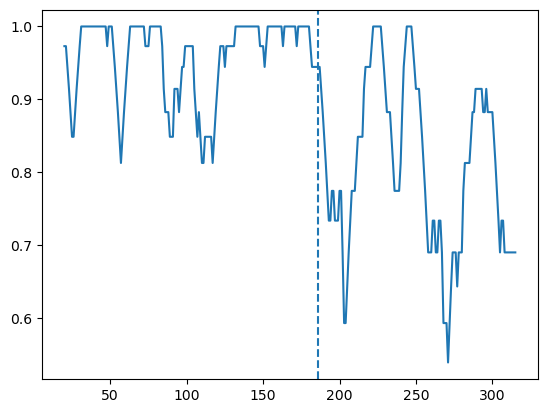

In [130]:
#Visualization

x_ser = pd.Series(logVar_global["activity"][0])

x_win = generate_timeS(x_ser, jaccard_distance_bigram,20)

x_win.plot.line(x='lab', y='val', rot=0)
plt.axvline(x=logVar_global['cpoint'][0], ls='--')
#plt.xticks([0,20,40,60,80,100])
#plt.yticks([0,1.0,2.0,3.0,4.0,5.0])
#plt.xticks([0,25, 50, 75, 100, 125, 150, 175])

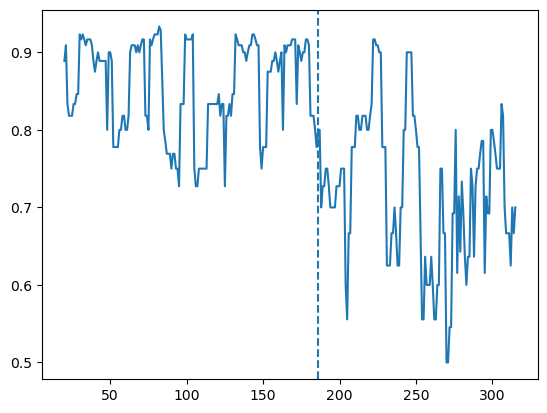

In [304]:
#Visualization

x_ser = pd.Series(logVar_global["activity"][0])

x_win = generate_timeS(x_ser, jaccGraphSim,20)

x_win.plot.line(x='lab', y='val', rot=0)
plt.axvline(x=logVar_global['cpoint'][0], ls='--')
#plt.xticks([0,20,40,60,80,100])
#plt.yticks([0,1.0,2.0,3.0,4.0,5.0])
#plt.xticks([0,25, 50, 75, 100, 125, 150, 175])